# Appendix D: Further modeling and diagnostics

In this Appendix I construct competing linear models to g03 from Part01, drawing upon the material found in Julian Faraway's *Extending the Linear Model with R*.  g03 is a good balance between predictive performance and transparency; it has an R-squared of 73.4\% and, with only 6 predictors and 16 terms (including the intercept), it sheds some light on the relationship between the response variable (median_house_value) and the 6 predictors.

Many of the models that follow include 8 predictors and 20 or more terms.  The increased complexity makes it somewhat more difficult to see the value each of the predictors has for predicting the response.  This is especially true for the models with a large number of interaction terms.  But the complexity brings with it much greater predictive power.  The m04 additive model below, for example, has an R-squared over 80\% and a comparative rmse score that is \\$12,000 less than what we saw for the g03 model.  Although this predictive power is still less than that of the xgboost and random forest models of Part02, the models below are far less complex and computationally intensive.  The models below are also less opaque regarding the relationship between the predictors and the response variable. 


## Preliminaries

In [1]:
options(digits = 5, show.signif.stars = F, 
        mc.cores=parallel::detectCores())


In [ ]:
# Some packages we will need.

require(corrgram)
require(GGally)  # for scatterplot "tool"
require(repr)    # allows us to resize the plots
require(stringr)
require(ggplot2)
require(car)     # needed for diagnostic tools
require(arm)     # needed for Gibbs sampling used in imputation

require(faraway)


In [3]:
train <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/train_revised_07DEC2021.csv",
                header=TRUE, row.names=1,
                colClasses= c("character", rep("numeric", 9), "character",
                              rep("numeric", 5), "character"))
dim(train)
# 16,482    16

colnames(train)


[1] 16482    16

[1] "longitude"          "latitude"           "housing_median_age"
 [4] "total_rooms"        "total_bedrooms"     "population"        
 [7] "households"         "median_income"      "median_house_value"
[10] "ocean_proximity"    "rooms_per_hh"       "bdrms_per_room"    
[13] "pop_per_hh"         "HHdens_ln"          "long_transf"       
[16] "income_cat"

In [4]:
# Select out only the columns that we know are most important
# for modeling.  The predictors that are dropped are mainly 
# dropped due to collinearity.  See the corrgrams in Part01.

# Predictors total_rooms and rooms_per_hh were not used in 
# the g03 model of Part01.

dat <- train[, c("median_house_value","median_income","HHdens_ln",
                 "housing_median_age","latitude","long_transf",
                 "pop_per_hh","total_rooms","rooms_per_hh")]


In [5]:
# The total_rooms predictor needs to be transformed.

summary(dat$total_rooms)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      6    1446    2130    2640    3167   39320 

In [6]:
dat$total_rooms <- log(dat$total_rooms)
summary(dat$total_rooms)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.79    7.28    7.66    7.63    8.06   10.58 

In [7]:
# Create data for checking correlations.  Leave out latitude
# and long_transf terms since I know I want these predictors 
# in the model.

tmpdat <- dat[, c("median_income","HHdens_ln","housing_median_age",
                  "pop_per_hh","total_rooms","rooms_per_hh")]


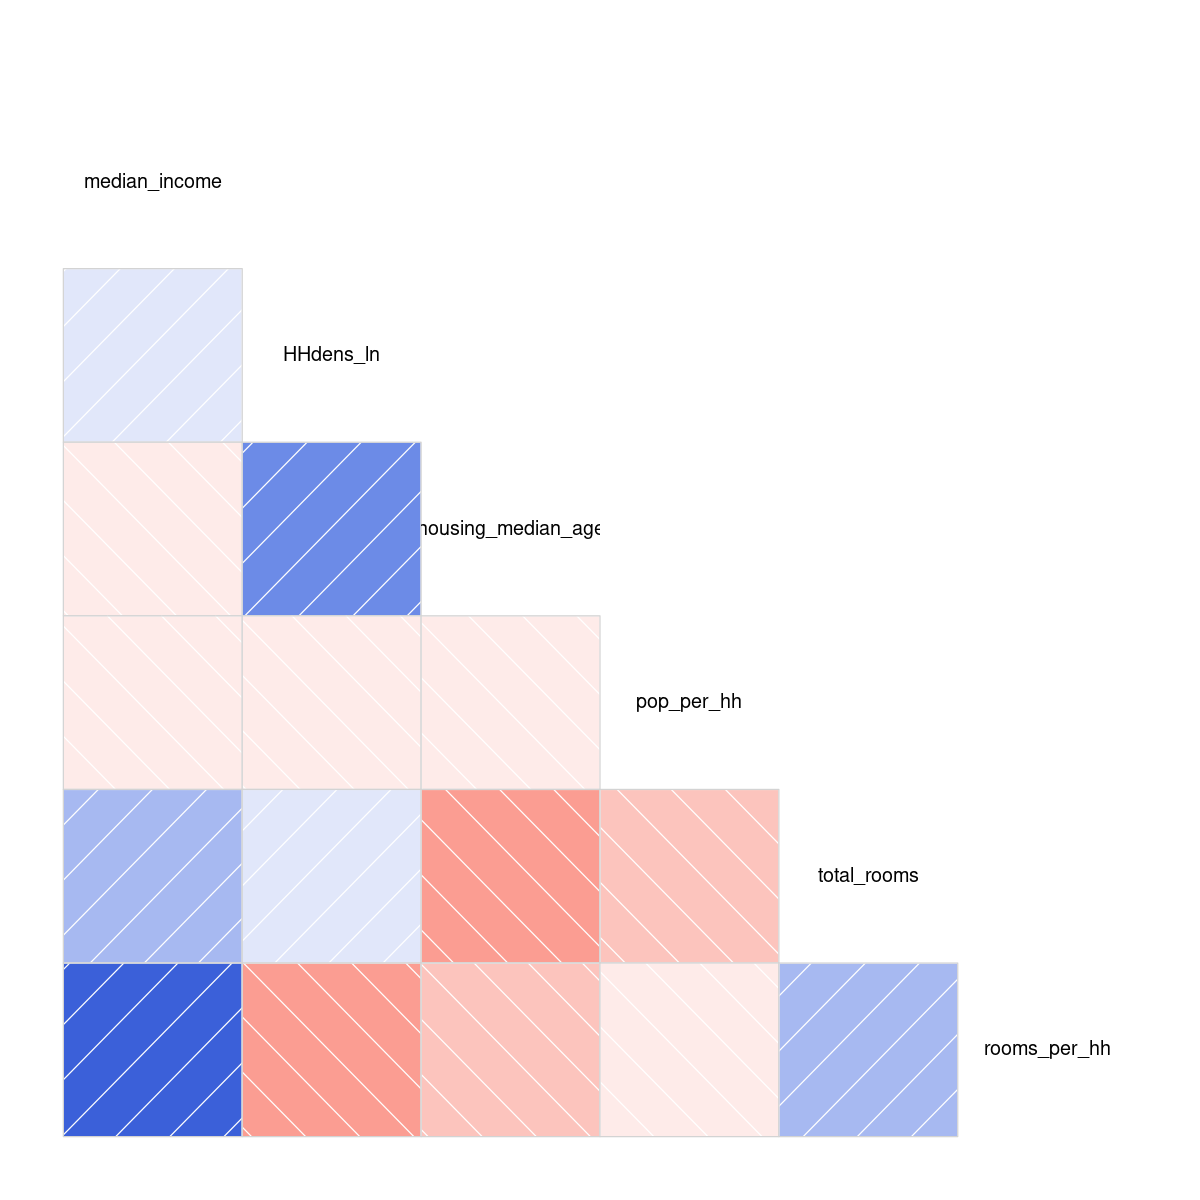

In [8]:
# Darker colors represent higher correlations.  Blue is for
# positive correlations; red is for negative correlations.

options(repr.plot.width= 10, repr.plot.height= 10)

# The following function is from package corrgram.
corrgram(tmpdat, lower.panel=panel.shade, upper.panel=NULL,
        text.panel=panel.txt, main="", cex=1.5)


In [9]:
# Correlation between rooms_per_hh and median_income:

print(round(cor(tmpdat$median_income, tmpdat$rooms_per_hh), 3))
# [1] 0.466


[1] 0.466


In [ ]:
### COMMENT:

# I do not see any reason at this point to remove 
# additional predictors.


## AIC for model g03

In [12]:
response_var_power <- 0.103

g03 <- lm(I(median_house_value^response_var_power) ~ 
          
           I(median_income^0.825) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           pop_per_hh +
           I(pop_per_hh^2) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
                  
           data= train)  

g03.summary <- summary(g03)
g03.summary[[1]] <- ""; round(g03.summary$adj.r.squared, 3)


[1] 0.734

In [13]:
# A slight change in response_var_power can produce
# a very different AIC score.

round(AIC(g03))
# -26,352


[1] -26352

In [14]:
# See what the contributions are from the interaction terms.
# These contributions depend on the order of the terms in
# the model.

anova(g03)


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
I(median_income^0.825),1,345.86715,345.867149,29256.687,0.0000e+00
I(long_transf^-0.5),1,101.60141,101.601409,8594.400,0.0000e+00
I(long_transf^-1),1,5.90771,5.907714,499.730,4.5429e-109
I(long_transf^-1.5),1,17.37589,17.375894,1469.816,4.1720e-308
latitude,1,1.10175,1.101746,93.196,5.4165e-22
I(latitude^2),1,6.19190,6.191903,523.769,3.8436e-114
I(latitude^3),1,0.48291,0.482914,40.849,1.6884e-10
I(latitude^4),1,15.37256,15.372556,1300.355,3.8718e-274
pop_per_hh,1,26.74812,26.748120,2262.607,0.0000e+00


In [ ]:
### COMMENT:

# From the above sum of squares output, it is not clear
# that we really need housing_median_age in our model
# given the other 5 predictors.


## Models without power transformations on the predictors

In [15]:
# Check the range of the response variable.

summary(dat$median_house_value)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  15000  120000  180050  212313  265500  766141 

In [16]:
# See p.21 of Faraway.  In order to compare models using
# AIC scores, I need to have the same transformation on 
# the response variable.

big_f01 <- lm(I(median_house_value^0.103) ~
          (median_income+long_transf+latitude+HHdens_ln+
           housing_median_age+pop_per_hh+total_rooms+
           rooms_per_hh)^2, data=dat)


In [17]:
# Eliminate unnecessary terms from big_f01.

f01 <- step(big_f01, trace=FALSE)
f01_sum <- summary(f01)
round(AIC(f01))
round(AIC(g03))
# -24858
# -26352


[1] -24858

[1] -26352

In [18]:
# Compute the number of terms in f01 and in g03.

length(f01_sum$coeff)/4
# 32

length(g03.summary$coeff)/4
# 16


[1] 32

[1] 16

In [19]:
ncvTest(f01)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 11.533, Df = 1, p = 0.000684

In [20]:
round(f01_sum$adj.r.squared, 4)


[1] 0.7087

In [21]:
round(f01_sum$sigma, 4)
round(g03.summary$sigma, 4)


[1] 0.1137

[1] 0.1087

In [ ]:
### COMMENTS:

# The g03 model is better than f01, having only
# half the number of terms and a much better R-sqrd.


In [33]:
anova(f01)


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
median_income,1,338.983284,338.983284,26215.4684,0.0000e+00
long_transf,1,104.278071,104.278071,8064.4050,0.0000e+00
latitude,1,0.940477,0.940477,72.7324,1.6122e-17
HHdens_ln,1,9.949712,9.949712,769.4667,1.4816e-165
housing_median_age,1,1.432454,1.432454,110.7797,7.9884e-26
pop_per_hh,1,28.077377,28.077377,2171.3802,0.0000e+00
total_rooms,1,0.700593,0.700593,54.1808,1.9150e-13
rooms_per_hh,1,0.435691,0.435691,33.6945,6.5671e-09
median_income:long_transf,1,0.565305,0.565305,43.7182,3.9091e-11


In [23]:
# Create a model with polynomial terms.

big_f02 <- lm(I(median_house_value^0.103) ~ 
              
              poly(median_income, degree=3) +
              poly(long_transf, degree=3) +
              poly(latitude, 3) +
              poly(HHdens_ln, 3) +
              poly(housing_median_age, 3) +
              poly(pop_per_hh, 3) +
              poly(total_rooms, 3) +
              poly(rooms_per_hh, 3),
              
              data=dat)


In [24]:
# Eliminate unnecessary terms from big_f02.

f02 <- step(big_f02, trace=FALSE)
f02_sum <- summary(f02)
round(AIC(f02))
# -26123


[1] -26122

In [25]:
# Compute the number of terms in f02.

length(f02_sum$coeff)/4
# 25


[1] 25

In [26]:
summary(f02)



Call:
lm(formula = I(median_house_value^0.103) ~ poly(median_income, 
    degree = 3) + poly(long_transf, degree = 3) + poly(latitude, 
    3) + poly(HHdens_ln, 3) + poly(housing_median_age, 3) + poly(pop_per_hh, 
    3) + poly(total_rooms, 3) + poly(rooms_per_hh, 3), data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7533 -0.0633 -0.0038  0.0607  0.8791 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)
(Intercept)                       3.482248   0.000853 4084.23  < 2e-16
poly(median_income, degree = 3)1 17.051810   0.169959  100.33  < 2e-16
poly(median_income, degree = 3)2 -3.109912   0.117651  -26.43  < 2e-16
poly(median_income, degree = 3)3 -0.716858   0.110602   -6.48  9.3e-11
poly(long_transf, degree = 3)1   -8.554306   0.146422  -58.42  < 2e-16
poly(long_transf, degree = 3)2    2.099918   0.114625   18.32  < 2e-16
poly(long_transf, degree = 3)3    2.581946   0.117561   21.96  < 2e-16
poly(latitude, 3)1                0.02563

In [27]:
ncvTest(f02)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 15.713, Df = 1, p = 7.37e-05

In [28]:
# Adjust the polynomial model so that the ncv is reduced.

big_f03 <- lm(I(median_house_value^0.158) ~ 
              
              poly(median_income, degree=3) +
              poly(long_transf, degree=3) +
              poly(latitude, 3) +
              poly(HHdens_ln, 3) +
              poly(housing_median_age, 3) +
              poly(pop_per_hh, 3) +
              poly(total_rooms, 3) +
              poly(rooms_per_hh, 3),
              
              data=dat)


In [29]:
# Eliminate unnecessary terms from big_f03.

f03 <- step(big_f03, trace=FALSE)
f03_sum <- summary(f03)
round(AIC(f03))
# -26123


[1] 9952

In [30]:
ncvTest(f03)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.0033845, Df = 1, p = 0.954

In [31]:
# Compute the number of terms in f02.

length(f03_sum$coeff)/4
# 25


[1] 25

In [32]:
summary(f03)



Call:
lm(formula = I(median_house_value^0.158) ~ poly(median_income, 
    degree = 3) + poly(long_transf, degree = 3) + poly(latitude, 
    3) + poly(HHdens_ln, 3) + poly(housing_median_age, 3) + poly(pop_per_hh, 
    3) + poly(total_rooms, 3) + poly(rooms_per_hh, 3), data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.1305 -0.1891 -0.0136  0.1803  2.6503 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)
(Intercept)                        6.78973    0.00255 2665.82  < 2e-16
poly(median_income, degree = 3)1  51.36700    0.50771  101.17  < 2e-16
poly(median_income, degree = 3)2  -8.61390    0.35145  -24.51  < 2e-16
poly(median_income, degree = 3)3  -2.60564    0.33040   -7.89  3.3e-15
poly(long_transf, degree = 3)1   -25.28887    0.43740  -57.82  < 2e-16
poly(long_transf, degree = 3)2     6.29055    0.34241   18.37  < 2e-16
poly(long_transf, degree = 3)3     7.58149    0.35119   21.59  < 2e-16
poly(latitude, 3)1                 0.0664

In [ ]:
### COMMENTS:

# With an R-squared of 73.1%, the above polynomial model is 
# very competitive with g03.  Although not quite as transparent
# as g03, the above model required none of the labor-intensive
# tuning that g03 did.


In [34]:
# Model with orthogonal polynomials AND the most important
# interaction terms.

big_f04 <- lm(I(median_house_value^0.155) ~ 
              
              poly(median_income, degree=3) +
              poly(long_transf, degree=3) +
              poly(latitude, 3) +
              poly(HHdens_ln, 3) +
              poly(housing_median_age, 3) +
              poly(pop_per_hh, 3) +
              poly(total_rooms, 3) +
              poly(rooms_per_hh, 3) +
              
              long_transf:latitude +
              
              HHdens_ln:long_transf +
              HHdens_ln:median_income +
              HHdens_ln:housing_median_age:median_income +
              long_transf:housing_median_age +
              pop_per_hh:total_rooms +
              pop_per_hh:housing_median_age +
              HHdens_ln:pop_per_hh +
              housing_median_age:total_rooms +
              median_income:latitude +
              median_income:rooms_per_hh,
              
              data=dat)


In [35]:
# Eliminate unnecessary terms from big_f04.

f04 <- step(big_f04, trace=FALSE)
f04_sum <- summary(f04)
round(AIC(f04))
# 7128


[1] 7128

In [36]:
ncvTest(f04)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.0021336, Df = 1, p = 0.963

In [37]:
# Compute the number of terms in f02.

length(f04_sum$coeff)/4
# 35

# Model g03 from Part01 has only 16 terms.


[1] 35

In [38]:
round(f04_sum$adj.r.squared, 4)
# 0.7468

# g03's adj.r.squared is 73.4.


[1] 0.7468

In [ ]:
### COMMENT:

# In terms of R-sqrd, f04 is a much better model
# than g03.  However, it has more than 2X as many 
# terms; accordingly, it does not give us as clear
# an understanding of the relationship between the
# predictors and the response variable.


In [39]:
anova(f04)


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
"poly(median_income, degree = 3)",3,2.8439e+03,947.981961,1.0530e+04,0.0000e+00
"poly(long_transf, degree = 3)",3,9.0740e+02,302.467163,3.3598e+03,0.0000e+00
"poly(latitude, 3)",3,5.1277e+01,17.092337,1.8986e+02,4.8251e-121
"poly(HHdens_ln, 3)",3,2.1304e+02,71.013266,7.8881e+02,0.0000e+00
"poly(housing_median_age, 3)",3,1.0673e+01,3.557768,3.9519e+01,1.9441e-25
"poly(pop_per_hh, 3)",3,2.4140e+02,80.466488,8.9382e+02,0.0000e+00
"poly(total_rooms, 3)",3,8.6865e+00,2.895514,3.2163e+01,1.0143e-20
"poly(rooms_per_hh, 3)",3,8.3188e+00,2.772921,3.0801e+01,7.5691e-20
long_transf:latitude,1,3.6496e+01,36.496434,4.0540e+02,4.3469e-89


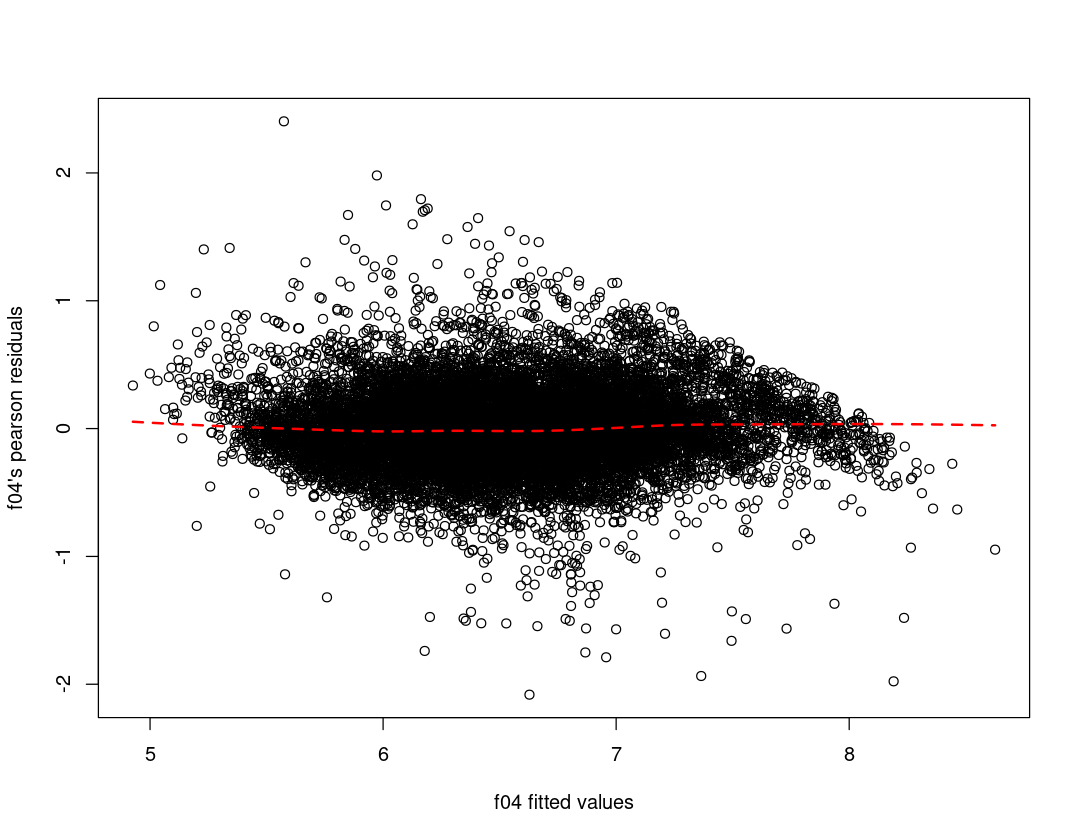

In [150]:
# Check linearity.  (We already know we have constant variance 
# with respect to the fitted values.)

options(repr.plot.width= 9, repr.plot.height= 7)

plot(f04$fitted, residuals(f04, "pearson"), xlab="f04 fitted values",
     ylab="f04's pearson residuals")
lines(lowess(f04$fitted, residuals(f04, "pearson")), col="red", lty=2, lwd=2)


In [ ]:
### COMMENTS:

# The above plot indicates that we have approximate linearity
# with respect to the fitted values.  The line for the lowess
# smooth is not as straight as it could be.


In [40]:
rm(big_f01, f01, f01_sum, big_f02, f02, f02_sum,
   big_f03, f03, f03_sum)


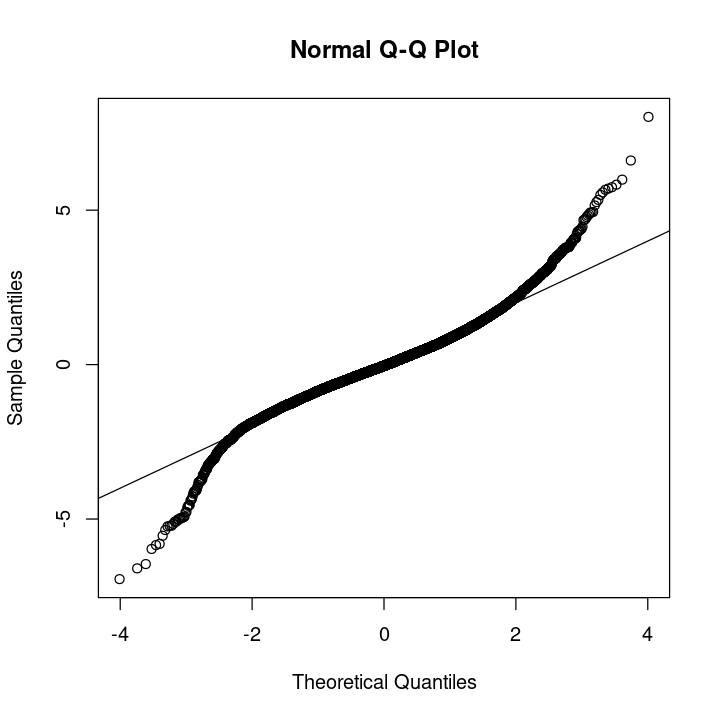

In [41]:
# Check the normality of the response.

options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(f04, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [42]:
# Another measure of linearity with respect to the fitted values.

residualPlots(f04, plot=FALSE)


                                Test stat Pr(>|Test stat|)
poly(median_income, degree = 3)                           
poly(long_transf, degree = 3)                             
poly(latitude, 3)                                         
poly(HHdens_ln, 3)                                        
poly(housing_median_age, 3)                               
poly(pop_per_hh, 3)                                       
poly(total_rooms, 3)                                      
poly(rooms_per_hh, 3)                                     
Tukey test                           8.98           <2e-16


## Additive models

In [ ]:
require(mgcv)


In [162]:
m01 <- gam(I(median_house_value^0.05) ~
          
           s(median_income) +
           s(HHdens_ln) +
           s(long_transf) +
           s(latitude) +
           s(housing_median_age) +
           s(pop_per_hh) +
           s(total_rooms) +
           s(rooms_per_hh), 
           
          data= dat)

(m01.sum <- summary(m01))



Family: gaussian 
Link function: identity 

Formula:
I(median_house_value^0.05) ~ s(median_income) + s(HHdens_ln) + 
    s(long_transf) + s(latitude) + s(housing_median_age) + s(pop_per_hh) + 
    s(total_rooms) + s(rooms_per_hh)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept) 1.831640   0.000197    9298   <2e-16

Approximate significance of smooth terms:
                       edf Ref.df      F p-value
s(median_income)      8.16   8.81 728.92  <2e-16
s(HHdens_ln)          8.20   8.83  62.16  <2e-16
s(long_transf)        8.62   8.96 638.26  <2e-16
s(latitude)           8.96   9.00 274.80  <2e-16
s(housing_median_age) 8.32   8.78   9.26  <2e-16
s(pop_per_hh)         8.90   9.00 319.27  <2e-16
s(total_rooms)        4.99   6.16  16.66  <2e-16
s(rooms_per_hh)       8.15   8.81  41.28  <2e-16

R-sq.(adj) =  0.779   Deviance explained =   78%
GCV = 0.00064208  Scale est. = 0.00063954  n = 16482

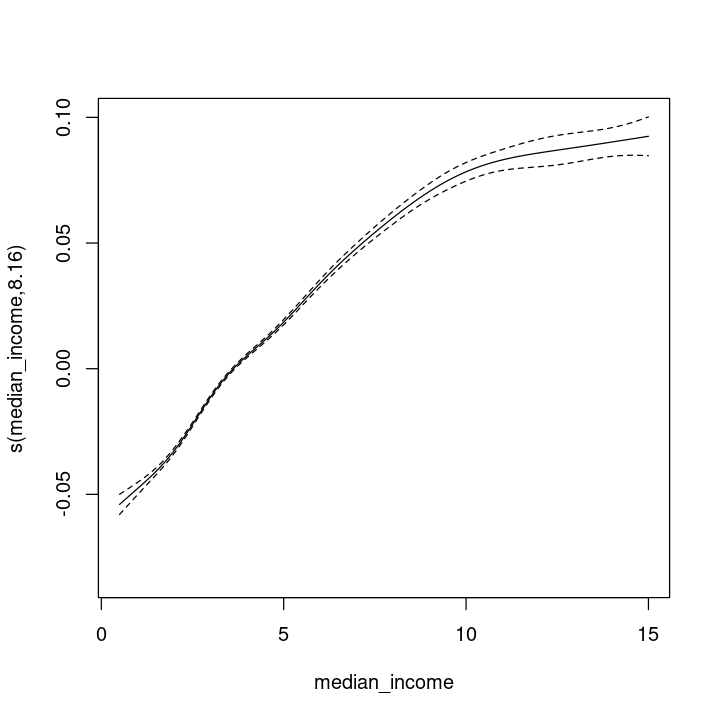

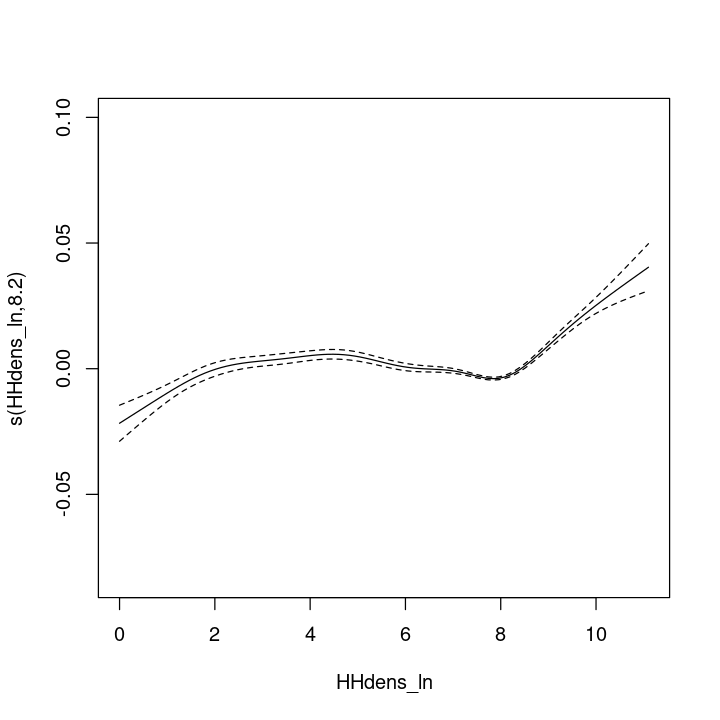

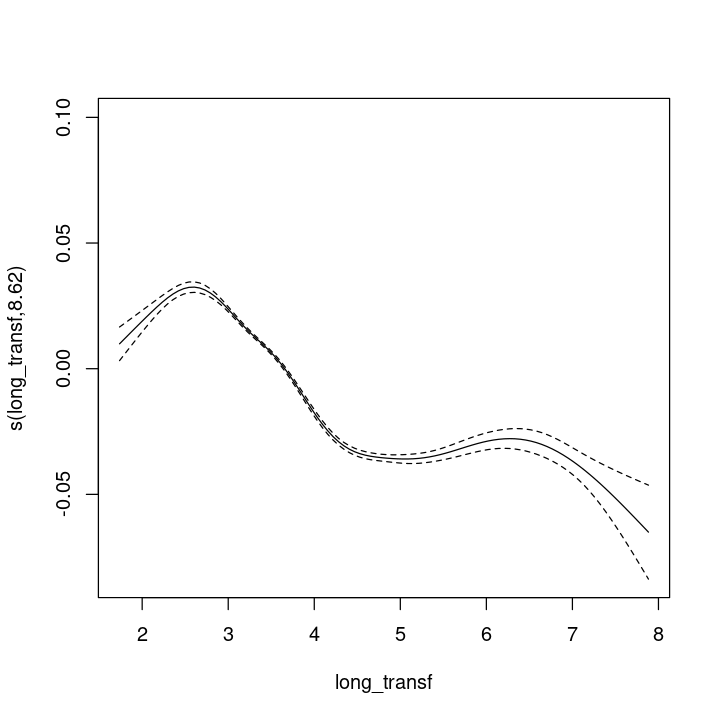

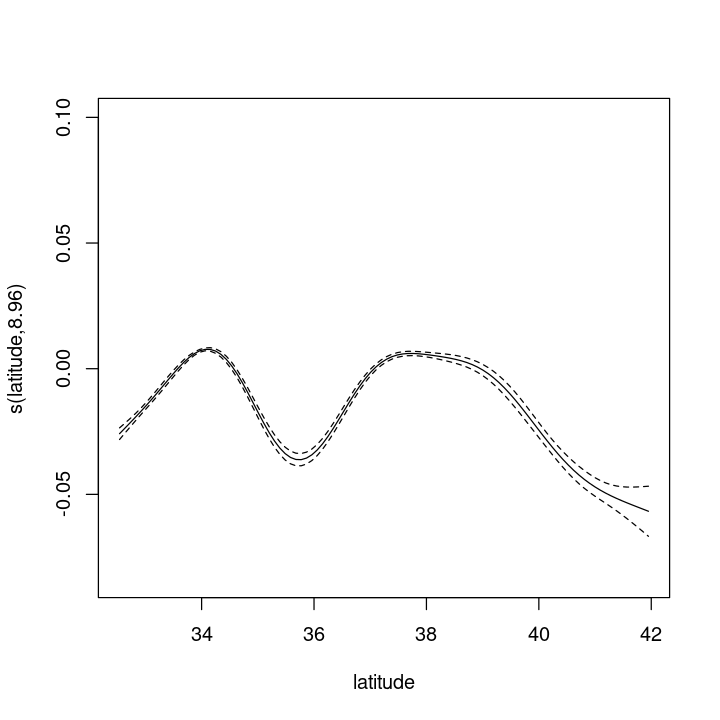

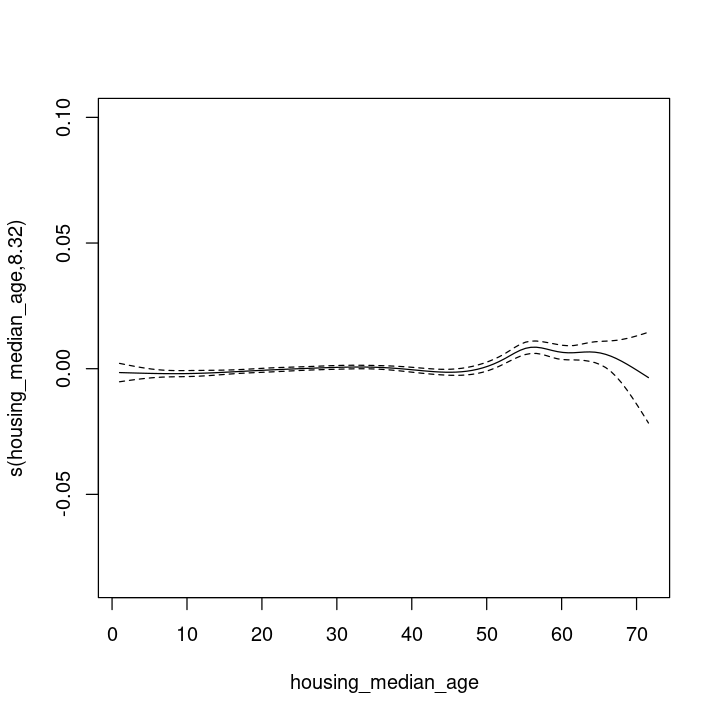

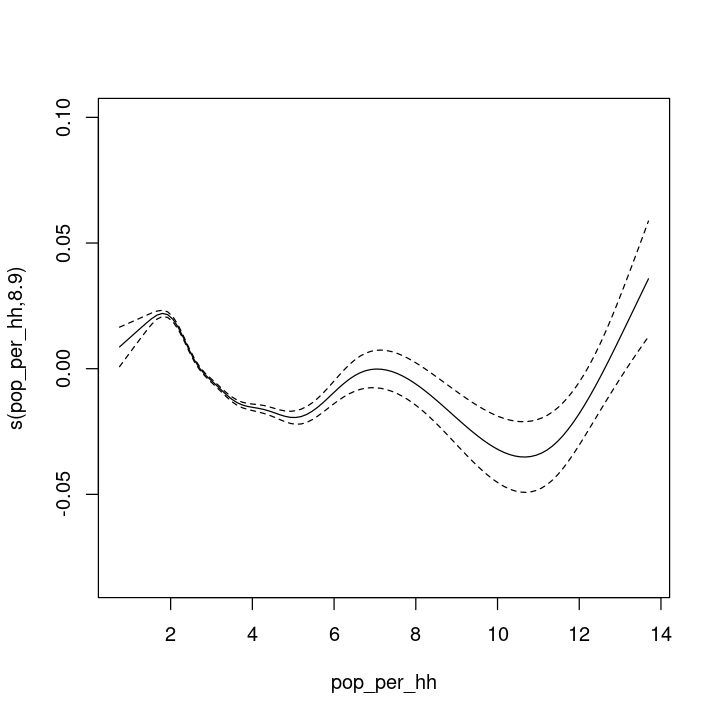

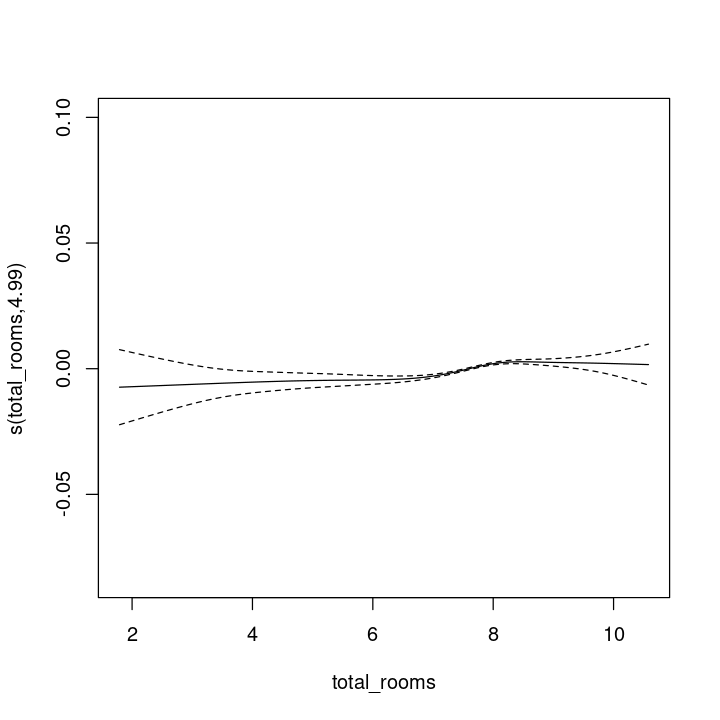

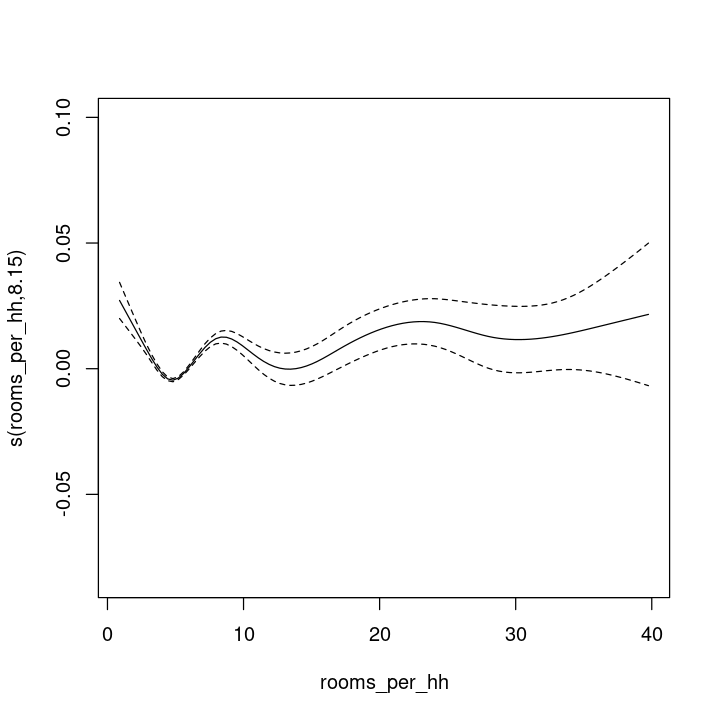

In [163]:
options(repr.plot.width= 6, repr.plot.height= 6)

plot(m01)


In [168]:
# We know from previous models that we likely need some
# interaction terms.

m02 <- gam(I(log(median_house_value)) ~
          
           s(median_income) +
           s(HHdens_ln) +
           s(long_transf, latitude) +
           s(long_transf, housing_median_age) +
           s(housing_median_age, pop_per_hh) +
           s(total_rooms) +
           s(rooms_per_hh), 
           
          data= dat)

(m02.sum <- summary(m02))



Family: gaussian 
Link function: identity 

Formula:
I(log(median_house_value)) ~ s(median_income) + s(HHdens_ln) + 
    s(long_transf, latitude) + s(long_transf, housing_median_age) + 
    s(housing_median_age, pop_per_hh) + s(total_rooms) + s(rooms_per_hh)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept) 12.09561    0.00206    5870   <2e-16

Approximate significance of smooth terms:
                                    edf Ref.df     F p-value
s(median_income)                   8.10   8.78 597.8  <2e-16
s(HHdens_ln)                       8.42   8.91  46.3  <2e-16
s(long_transf,latitude)           28.59  28.99 248.6  <2e-16
s(long_transf,housing_median_age) 25.53  27.39  12.2  <2e-16
s(housing_median_age,pop_per_hh)  28.00  28.00 120.8  <2e-16
s(total_rooms)                     4.34   5.45  13.8  <2e-16
s(rooms_per_hh)                    7.97   8.72  42.4  <2e-16

R-sq.(adj) =  0.797   Deviance explained = 79.9%
GCV = 0.070462  Scale est. = 0.0699

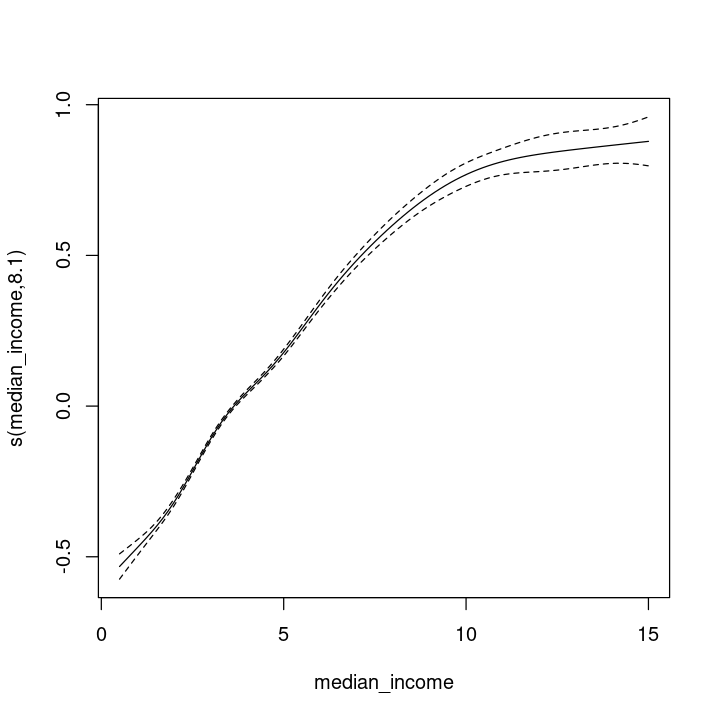

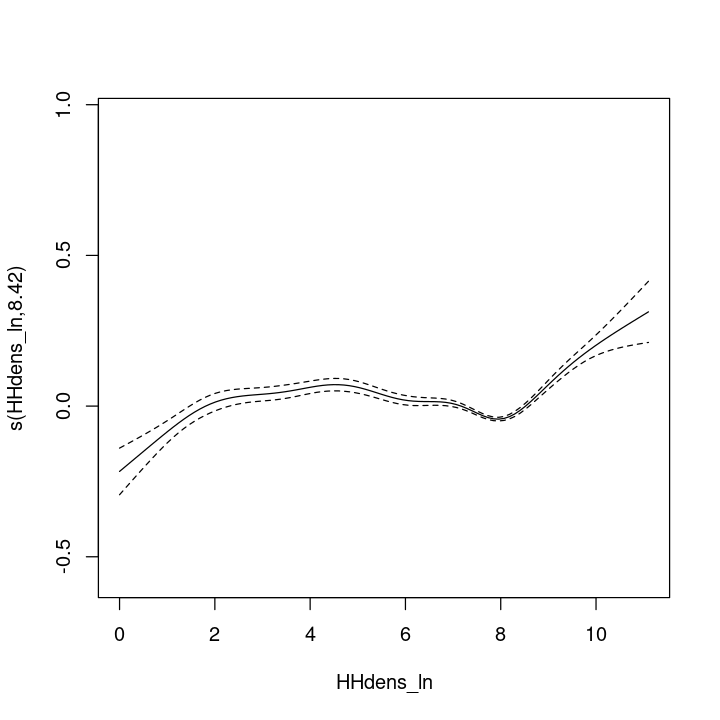

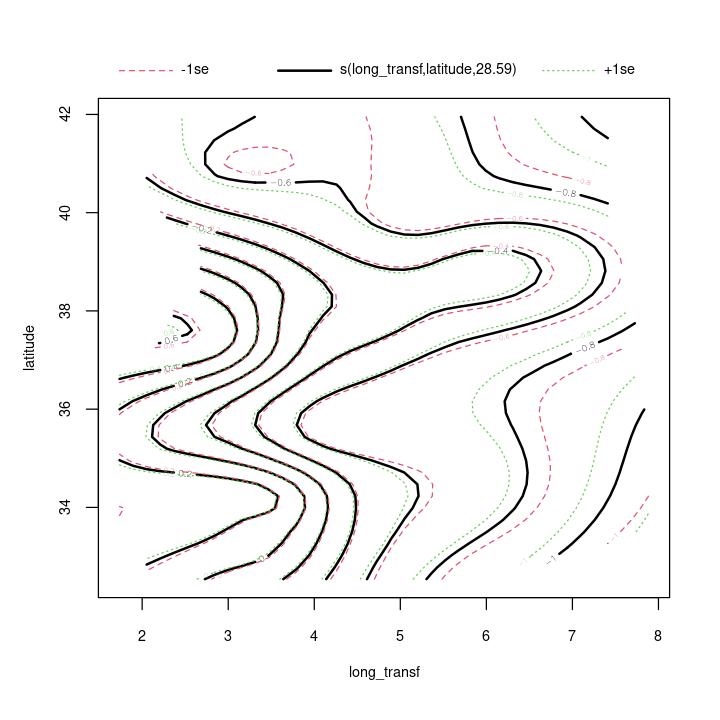

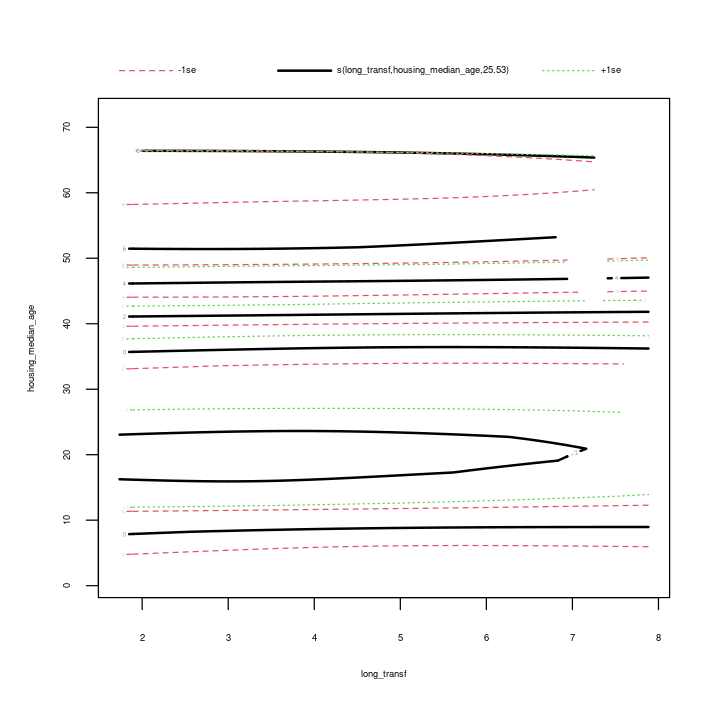

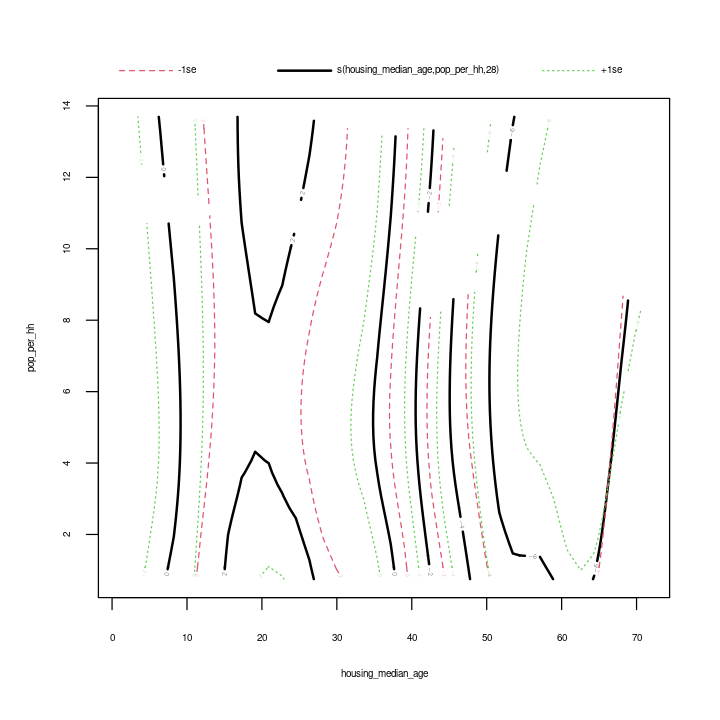

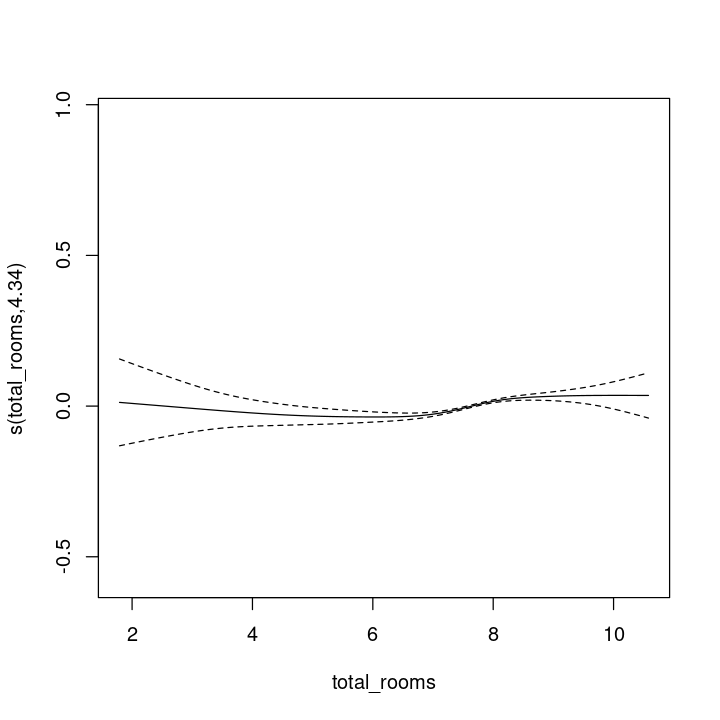

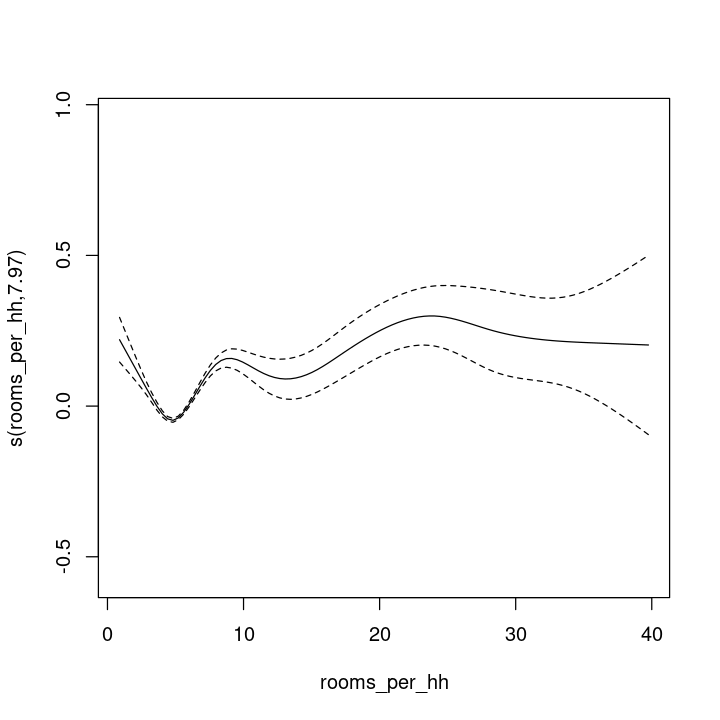

In [169]:
options(repr.plot.width= 6, repr.plot.height= 6)

plot(m02)


In [170]:
# Add another interaction.

m03 <- gam(I(log(median_house_value)) ~
          
           s(median_income, rooms_per_hh) +
           s(HHdens_ln) +
           s(long_transf, latitude) +
           s(long_transf, housing_median_age) +
           s(housing_median_age, pop_per_hh) +
           s(total_rooms), 
           
          data= dat)

(m03.sum <- summary(m03))



Family: gaussian 
Link function: identity 

Formula:
I(log(median_house_value)) ~ s(median_income, rooms_per_hh) + 
    s(HHdens_ln) + s(long_transf, latitude) + s(long_transf, 
    housing_median_age) + s(housing_median_age, pop_per_hh) + 
    s(total_rooms)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept) 12.09561    0.00205    5895   <2e-16

Approximate significance of smooth terms:
                                    edf Ref.df     F p-value
s(median_income,rooms_per_hh)     26.49  28.61 486.4  <2e-16
s(HHdens_ln)                       8.44   8.92  44.9  <2e-16
s(long_transf,latitude)           28.57  28.99 240.1  <2e-16
s(long_transf,housing_median_age) 25.33  27.32  11.7  <2e-16
s(housing_median_age,pop_per_hh)  28.00  28.00 120.5  <2e-16
s(total_rooms)                     4.36   5.47  13.0  <2e-16

R-sq.(adj) =  0.799   Deviance explained = 80.1%
GCV = 0.069908  Scale est. = 0.06939   n = 16482

In [44]:
# I have tested various power transformations on the response
# variable.  The log transformation seems to work best.

m04 <- gam(I(log(median_house_value)) ~
          
           s(median_income, rooms_per_hh) +
           s(HHdens_ln, median_income) +
           s(long_transf, latitude) +
           s(long_transf, housing_median_age) +
           s(housing_median_age, pop_per_hh) +
           s(total_rooms, housing_median_age), 
           
          data= dat)

(m04.sum <- summary(m04))



Family: gaussian 
Link function: identity 

Formula:
I(log(median_house_value)) ~ s(median_income, rooms_per_hh) + 
    s(HHdens_ln, median_income) + s(long_transf, latitude) + 
    s(long_transf, housing_median_age) + s(housing_median_age, 
    pop_per_hh) + s(total_rooms, housing_median_age)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept) 12.09561    0.00204    5933   <2e-16

Approximate significance of smooth terms:
                                   edf Ref.df      F p-value
s(median_income,rooms_per_hh)     24.7   27.4  30.38  <2e-16
s(HHdens_ln,median_income)        24.3   26.7  20.21  <2e-16
s(long_transf,latitude)           28.6   29.0 246.22  <2e-16
s(long_transf,housing_median_age) 19.0   23.3   9.10  <2e-16
s(housing_median_age,pop_per_hh)  28.0   28.0 117.61  <2e-16
s(total_rooms,housing_median_age) 25.4   27.4   6.28  <2e-16

R-sq.(adj) =  0.802   Deviance explained = 80.3%
GCV = 0.069144  Scale est. = 0.06851   n = 16482

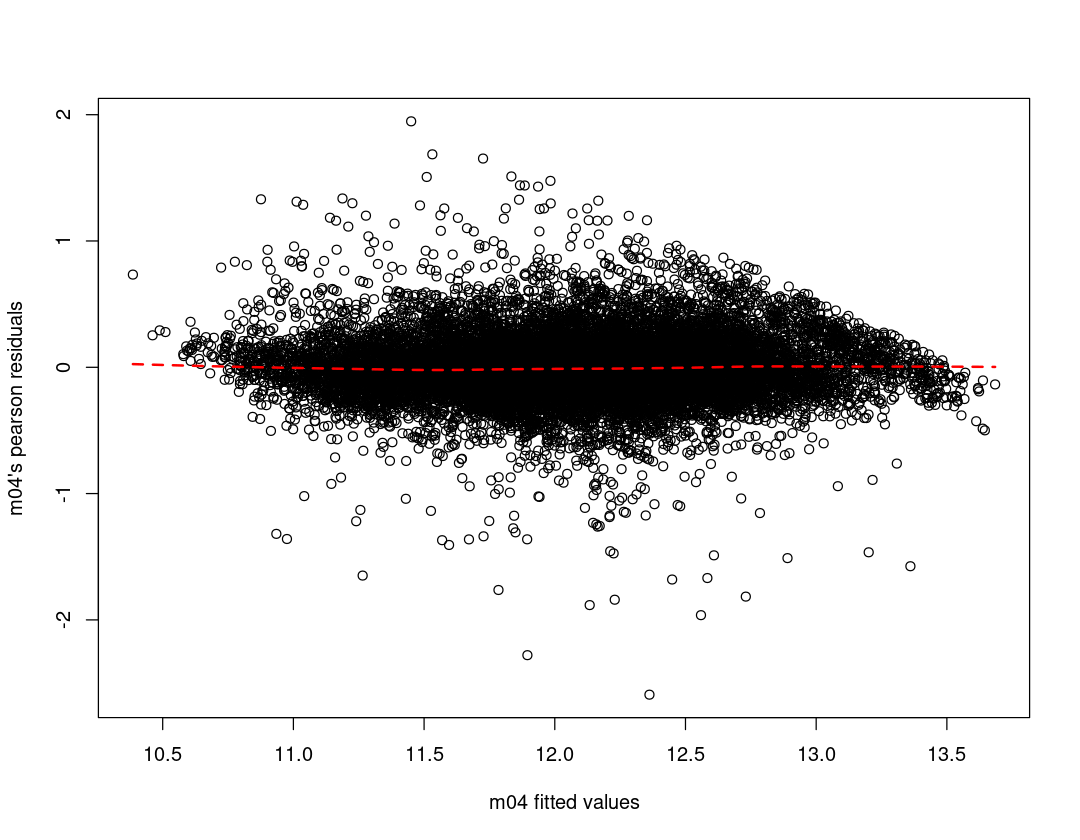

In [180]:
# Model diagnostic for linearity with respect to the fitted values
# and constant variance.

options(repr.plot.width= 9, repr.plot.height= 7)

plot(m04$fitted, residuals(m04, "pearson"), xlab="m04 fitted values",
     ylab="m04's pearson residuals")
lines(lowess(m04$fitted, residuals(m04, "pearson")), col="red", lty=2, lwd=2)


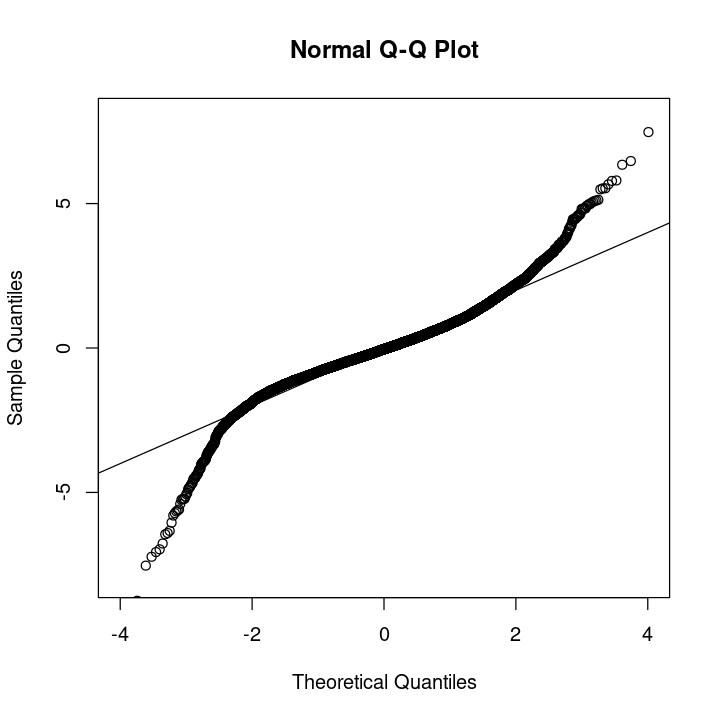

In [185]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(m04, type= "pearson")), ylim=c(-8, 8))
qqline(ans$x, probs = c(0.25, 0.75))


### Compute m04 rmse on the training set

In [46]:
predictions <- m04$fitted
preds_transf <- exp(predictions)

print(round(sqrt((1/nrow(dat)) * sum((as.numeric(preds_transf) - 
                                          dat$median_house_value)^2))))
# 63,888

# For the g03 model, we have: 76,047


[1] 63888


### Compute m04 rmse on the test set

In [17]:
testdat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/test_revised_07DEC2021.csv",
                    header=TRUE, row.names=1,
                    colClasses= c("character", rep("numeric", 9), "character",
                                  rep("numeric", 5), "character"))

test <- testdat[, c("median_house_value","median_income","HHdens_ln",
                 "housing_median_age","latitude","long_transf",
                 "pop_per_hh","total_rooms","rooms_per_hh")]

# Transform total_rooms.
test$total_rooms <- log(test$total_rooms)
dim(test)
#  4121   9


[1] 4121    9

In [18]:
summary(test$total_rooms)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.89    7.29    7.66    7.64    8.03   10.32 

In [49]:
predictions <- predict(m04, newdata = test)
preds_transf <- exp(predictions)

print(round(sqrt((1/nrow(test)) * sum((as.numeric(preds_transf) - 
                                          test$median_house_value)^2))))
# 64,741

# For the g03 model we had: 76,952


[1] 64741


In [50]:
# Get rmse score on the testset when median_house_value < 500K.
# (Slightly less than 200 records are dropped.)

newtest <- test[which(test$median_house_value < 500000),]
dim(newtest)
# 3924     9

predictions <- predict(m04, newdata = newtest)
preds_transf <- exp(predictions)

print(round(sqrt((1/nrow(newtest)) * sum((as.numeric(preds_transf) - 
                                          newtest$median_house_value)^2))))
# 49,245

# For the g03 model we had: 55,585


[1] 3924    9

[1] 49245


## Comparative rmse score for model m04

The following scores are what we use to compare against the models in Part02.

In [51]:
# Function for obtaining a set of scores on the testset data
# using model m04.

n_rcds <- 1000

get_testdatScores_m04 <- function(seedv, dat) {
    
    seedv_len <- length(seedv)
    vout <- rep(NA, seedv_len)
    lst <- vector("list", length=2)
    names(lst) <- c("mean","sd")
    
    for(h in 1:seedv_len) {

        set.seed(seedv[h])
        # It is expected that dat is testdat, which has 4K rcds
        smp <- sample(rownames(dat), n_rcds, replace= FALSE)
        df <- dat[smp,]
        
        preds <- predict(m04, newdata= df)
        preds_transf <- exp(preds)

        vout[h] <- round(sqrt((1/n_rcds) * sum((as.numeric(preds_transf) - 
                                          df$median_house_value)^2)))
    }
    
    lst[[1]] <- round(mean(vout))
    lst[[2]] <- round(sd(vout))
    return(lst)
}


In [52]:
# First shuffle the test data.

set.seed(6514)
smp01 <- sample(rownames(test), nrow(test), replace=FALSE)
test <- test[smp01,]
smp02 <- sample(rownames(test), nrow(test), replace=FALSE)
test <- test[smp02,]


In [193]:
# Get comparative rmse score for model m04.

set.seed(1821)
seed_vector <- sample(1:9999, 500, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
m04_info <- get_testdatScores_m04(seed_vector, test)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 3.02 mins

# For g03 the time difference was 1.12 mins


# This is the average rmse for model m04:
print(m04_info[[1]])
# 64,700

# For g03 we had: 76,773


# This is the average stddev for the m04 predictions:
print(m04_info[[2]])
# 3,078

# For g03 we had: 4,265


[1] "Start time: 2022-01-30 15:57:51"

Time difference of 3.02 mins

[1] 64700
[1] 3078


In [194]:
# Get a comparative rmse score for model m04 when 
# testdat$median_house_value < 500K.

newdat <- test[which(test$median_house_value < 500000),]

set.seed(1821)
seed_vector <- sample(1:9999, 500, replace=FALSE)

start <- Sys.time()
# paste("Start time: ", start, sep="")
m04_info02 <- get_testdatScores_m04(seed_vector, newdat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 3.4 mins

# Average rmse when predicting for districts whose real value is < 500K:
print(m04_info02[[1]])
# 49,172

# For g03 we had: 55,605


# Corresponding rmse stddev:
print(m04_info02[[2]])
# 1,645

# For g03 we had: 3,235


Time difference of 3.4 mins

[1] 49172
[1] 1645


In [ ]:
### COMMENTS:

# Of the models surveyed in this appendix, the m04 
# additive model is our best model so far in terms
# of predictive power.


## Variant of m04

In [54]:
# Add more interaction terms.

m05 <- gam(I(log(median_house_value)) ~
          
           s(median_income, rooms_per_hh) +
           s(HHdens_ln, median_income) +
           s(long_transf, latitude) +
           s(long_transf, HHdens_ln) +
           s(HHdens_ln, pop_per_hh) +
           s(pop_per_hh, total_rooms) +
           s(housing_median_age, pop_per_hh) +
           s(total_rooms, housing_median_age), 
           
          data= dat)

(m05.sum <- summary(m05))



Family: gaussian 
Link function: identity 

Formula:
I(log(median_house_value)) ~ s(median_income, rooms_per_hh) + 
    s(HHdens_ln, median_income) + s(long_transf, latitude) + 
    s(long_transf, HHdens_ln) + s(HHdens_ln, pop_per_hh) + s(pop_per_hh, 
    total_rooms) + s(housing_median_age, pop_per_hh) + s(total_rooms, 
    housing_median_age)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)   12.096      0.002    6034   <2e-16

Approximate significance of smooth terms:
                                   edf Ref.df      F p-value
s(median_income,rooms_per_hh)     24.2   27.2  28.76  <2e-16
s(HHdens_ln,median_income)        25.8   27.4   6.92  <2e-16
s(long_transf,latitude)           28.8   29.0 148.91  <2e-16
s(long_transf,HHdens_ln)          27.0   27.0   6.07  <2e-16
s(HHdens_ln,pop_per_hh)           27.7   28.0   9.27  <2e-16
s(pop_per_hh,total_rooms)         27.4   27.9   8.00  <2e-16
s(housing_median_age,pop_per_hh)  26.2   27.6  12.69  <2e-

### Compute m05 rmse on the training set

In [55]:
predictions <- m05$fitted
preds_transf <- exp(predictions)

print(round(sqrt((1/nrow(dat)) * sum((as.numeric(preds_transf) - 
                                          dat$median_house_value)^2))))
# 62,737

# For the g03 model, we have: 76,047


[1] 62737


## Comparative rmse score for m05

In [56]:
# Function for obtaining a set of scores on the testset data
# using model m05.

n_rcds <- 1000

get_testdatScores_m05 <- function(seedv, dat) {
    
    seedv_len <- length(seedv)
    vout <- rep(NA, seedv_len)
    lst <- vector("list", length=2)
    names(lst) <- c("mean","sd")
    
    for(h in 1:seedv_len) {

        set.seed(seedv[h])
        # It is expected that dat is testdat, which has 4K rcds
        smp <- sample(rownames(dat), n_rcds, replace= FALSE)
        df <- dat[smp,]
        
        preds <- predict(m05, newdata= df)
        preds_transf <- exp(preds)

        vout[h] <- round(sqrt((1/n_rcds) * sum((as.numeric(preds_transf) - 
                                          df$median_house_value)^2)))
    }
    
    lst[[1]] <- round(mean(vout))
    lst[[2]] <- round(sd(vout))
    return(lst)
}


In [57]:
# Get comparative rmse score for model m05.

set.seed(1821)
seed_vector <- sample(1:9999, 500, replace=FALSE)

start <- Sys.time()
# paste("Start time: ", start, sep="")
m05_info <- get_testdatScores_m05(seed_vector, test)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 4.19 mins


# This is the average rmse for model m05:
print(m05_info[[1]])
# 64,328

# For m04 we had: 64,700


# This is the average stddev for the m05 predictions:
print(m05_info[[2]])
# 3,068

# For m04 we had: 3,078


Time difference of 4.19 mins

[1] 64328
[1] 3068


In [58]:
# Get a comparative rmse score for model m05 when 
# testdat$median_house_value < 500K.

newdat <- test[which(test$median_house_value < 500000),]

set.seed(1821)
seed_vector <- sample(1:9999, 500, replace=FALSE)

start <- Sys.time()
# paste("Start time: ", start, sep="")
m05_info02 <- get_testdatScores_m05(seed_vector, newdat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 2.6 mins

# Average rmse when predicting for districts whose real value is < 500K:
print(m05_info02[[1]])
# 49,436

# For m04 we had: 49,172


# Corresponding rmse stddev:
print(m05_info02[[2]])
# 2,048

# For m04 we had: 1,645


Time difference of 2.6 mins

[1] 49436
[1] 2048


In [ ]:
### COMMENTS:

# Although m05 has a slightly better rmse than m04 when
# we predict median house values for the full range of
# districts, its performance is worse than m04's for
# districts with a known median house value < 500K.

# Overall, the better model seems to be m04.  m05
# appears to suffer from overfitting.


In [ ]:
rm(big_f04, f04, f04_sum, m01, m02, m03, m04,
   m01.sum, m02.sum, m03.sum, m04.sum)


## Model using multivariate adaptive regression splines

See p. 247 of Julian Faraway's *Extending the Linear Model with R*.

In [ ]:
require(mda)


In [196]:
dim(dat)
colnames(dat)


[1] 16482     9

[1] "median_house_value" "median_income"      "HHdens_ln"         
[4] "housing_median_age" "latitude"           "long_transf"       
[7] "pop_per_hh"         "total_rooms"        "rooms_per_hh"

In [9]:
# We first create a model matrix.

a <- mars(dat[, -1], log(dat[, 1]), nk=20, degree=2)


In [10]:
# It is not helpful to have the intercept term in the model.
# But when we remove it, we have to ignore the R-sqrd.

summary(lm(dat[, 1] ~ a$x -1))



Call:
lm(formula = dat[, 1] ~ a$x - 1)

Residuals:
    Min      1Q  Median      3Q     Max 
-682828  -40457   -8923   27507  628149 

Coefficients:
      Estimate Std. Error t value Pr(>|t|)
a$x1    392578      11530   34.05  < 2e-16
a$x2     51195        860   59.52  < 2e-16
a$x3    -42652        506  -84.28  < 2e-16
a$x4    109510       6873   15.93  < 2e-16
a$x5    246122      15169   16.23  < 2e-16
a$x6     -1533       1130   -1.36  0.17492
a$x7     71996       1418   50.75  < 2e-16
a$x8      7017        376   18.65  < 2e-16
a$x9     27538       3536    7.79  7.3e-15
a$x10   -54109       2752  -19.66  < 2e-16
a$x11   -54937       2826  -19.44  < 2e-16
a$x12   -98067       6102  -16.07  < 2e-16
a$x13     5593       1611    3.47  0.00052
a$x14     2062       1918    1.08  0.28213
a$x15     -966        584   -1.65  0.09810

Residual standard error: 71800 on 16467 degrees of freedom
Multiple R-squared:  0.917,	Adjusted R-squared:  0.917 
F-statistic: 1.21e+04 on 15 and 16467 DF,  p-va

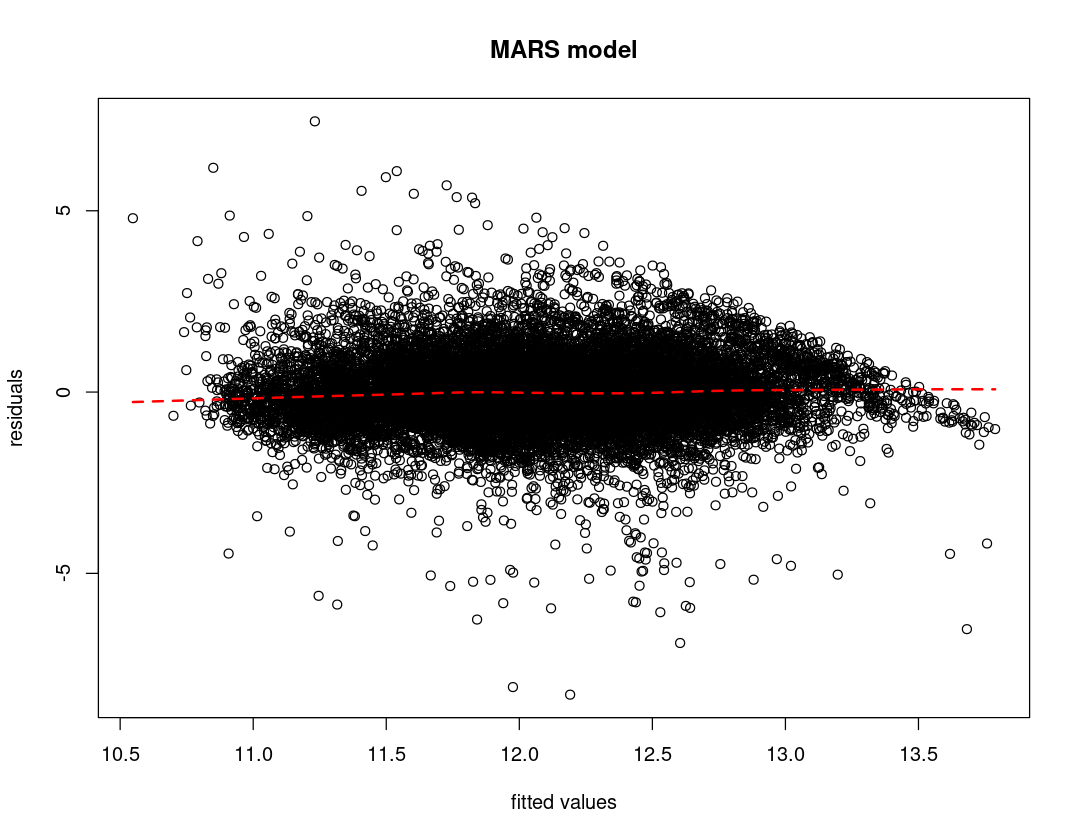

In [11]:
options(repr.plot.width= 9, repr.plot.height= 7)

plot(a$fit, scale(a$res), xlab="fitted values", ylab="residuals", main="MARS model")
lines(lowess(a$fit, scale(a$res)), col="red", lty=2, lwd=2)


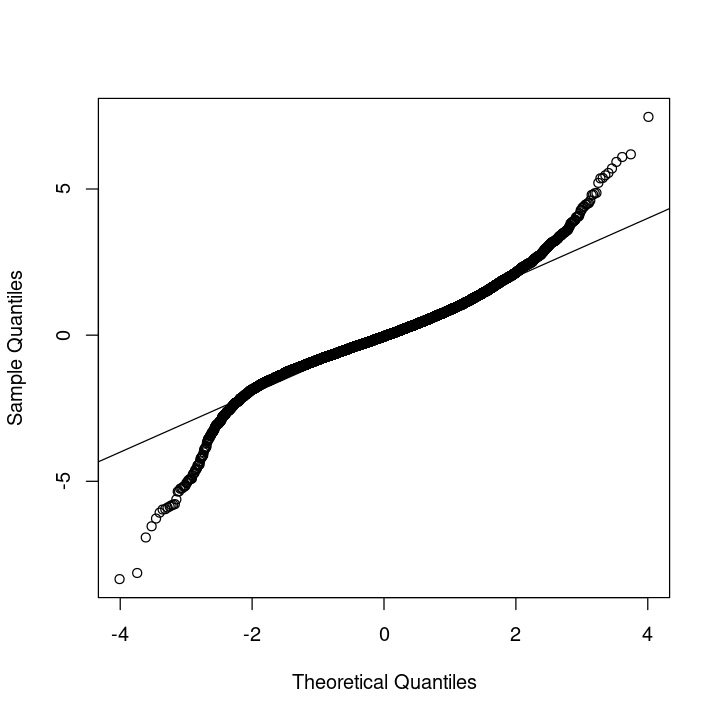

In [12]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(a$res), main="")
qqline(ans$x, probs = c(0.25, 0.75))


In [ ]:
### COMMENTS:

# Linearity, normality, and constant variance appear to
# be adequate when I take the log of the response variable.


### Compute the MARS model rmse on the training set

In [13]:
summary(a$fit)


       V1      
 Min.   :10.5  
 1st Qu.:11.8  
 Median :12.1  
 Mean   :12.1  
 3rd Qu.:12.5  
 Max.   :13.8  

In [15]:
print(round(sqrt((1/nrow(dat)) * sum((exp(a$fit) - 
                                      dat$median_house_value)^2))))
# 70,123

# For the m04 additive model we had: 63,888


[1] 70123


In [224]:
class(a)
names(a)


[1] "mars"

[1] "call"           "all.terms"      "selected.terms" "penalty"       
 [5] "degree"         "nk"             "thresh"         "gcv"           
 [9] "factor"         "cuts"           "residuals"      "fitted.values" 
[13] "lenb"           "coefficients"   "x"              "fit"

In [220]:
colnames(test)


[1] "median_house_value" "median_income"      "HHdens_ln"         
[4] "housing_median_age" "latitude"           "long_transf"       
[7] "pop_per_hh"         "total_rooms"        "rooms_per_hh"

In [19]:
preds <- predict(a, test[, -1])
preds_transf <- exp(preds)
summary(preds_transf)


       V1        
 Min.   : 48291  
 1st Qu.:124679  
 Median :177868  
 Mean   :202055  
 3rd Qu.:254839  
 Max.   :874128  

In [20]:
# Compute rmse for the test data.

print(round(sqrt((1/nrow(test)) * sum((as.numeric(preds_transf) - 
                                          test$median_house_value)^2))))
# 70,636

# For the m04 additive model we had: 64,741


[1] 70636


## Construct a MARS model with more terms

In [27]:
# We get a higher R-sqrd if we do not transform
# the response variable.

a <- mars(dat[, -1], dat[, 1], nk=30, degree=2)

round(summary(lm(dat[, 1] ~ a$x -1))$adj.r.squared, 4)


[1] 0.9301

In [73]:
# 40 terms in the model; degree= 3.

a <- mars(dat[, -1], dat[, 1], nk=40, degree=3)

round(summary(lm(dat[, 1] ~ a$x -1))$adj.r.squared, 4)


[1] 0.934

In [74]:
# Compute the rmse for the training set data.

a$fit[as.numeric(a$fit) < 15000] <- 15000

print(round(sqrt((1/nrow(dat)) * sum((as.numeric(a$fit) - 
                                          dat$median_house_value)^2))))
# 63,916


[1] 63916


In [75]:
# Compute for the test data.

preds_transf <- predict(a, test[, -1])
preds_transf[as.numeric(preds_transf) < 15000] <- 15000

print(round(sqrt((1/nrow(test)) * sum((as.numeric(preds_transf) - 
                                          test$median_house_value)^2))))
# 64,507

# For the m04 additive model we had: 64,741


[1] 64507


## Compute the comparative rmse score for the MARS model

In [76]:
# Function for obtaining a set of scores on the testset data
# using our "best" MARS model with 40 terms.

n_rcds <- 1000

get_testdatScores_mars <- function(seedv, dat) {
    
    seedv_len <- length(seedv)
    vout <- rep(NA, seedv_len)
    lst <- vector("list", length=2)
    names(lst) <- c("mean","sd")
    
    for(h in 1:seedv_len) {

        set.seed(seedv[h])
        # It is expected that dat is testdat, which has 4K rcds
        smp <- sample(rownames(dat), n_rcds, replace= FALSE)
        df <- dat[smp,]
        
        preds <- predict(a, newdata= df[, -1])
        preds[as.numeric(preds) < 15000] <- 15000

        vout[h] <- round(sqrt((1/n_rcds) * sum((as.numeric(preds) - 
                                          df$median_house_value)^2)))
    }
    
    lst[[1]] <- round(mean(vout))
    lst[[2]] <- round(sd(vout))
    return(lst)
}


In [77]:
# Get comparative rmse score for the 40-term MARS model.

set.seed(1821)
seed_vector <- sample(1:9999, 500, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
mars_info <- get_testdatScores_mars(seed_vector, test)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 1.92 seconds.

# For m04 the time difference was 3.02 mins


# This is the average rmse for the model:
print(mars_info[[1]])
# 64,461

# For m04 we had: 64,700


# This is the average stddev for the mars predictions:
print(mars_info[[2]])
# 2,854

# For m04 we had: 3,078


[1] "Start time: 2022-01-31 11:00:34"

Time difference of 1.92 secs

[1] 64461
[1] 2854


In [78]:
# Get a comparative rmse score for model m04 when 
# testdat$median_house_value < 500K.

newdat <- test[which(test$median_house_value < 500000),]

set.seed(1821)
seed_vector <- sample(1:9999, 500, replace=FALSE)

start <- Sys.time()
# paste("Start time: ", start, sep="")
mars_info02 <- get_testdatScores_mars(seed_vector, newdat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 1.88 secs

# For m04 the time difference was: 3.4 mins


# Average rmse when predicting for districts whose real value is < 500K:
print(mars_info02[[1]])
# 52,205

# For m04 we had: 49,172


# Corresponding rmse stddev:
print(mars_info02[[2]])
# 1,878

# For m04 we had: 1,645


Time difference of 1.88 secs

[1] 52205
[1] 1878


In [ ]:
### COMMENTS:

# The MARS model does slightly better than m04 on the full set
# of test data.  But it does not perform as well as m04 on the
# data for which we know the median house value is < 500K.

# Since most of the predictions we would make would be below
# 500K, m04 is the better model WHEN we know we are predicting
# for a district which will have a median house value < 500K.

# In general, the difference between the 2 models is small enough
# that we would say that, overall, m04 is the better model.  One
# deficiency, though, relative to the MARS model is that the latter
# is much, much faster when making predictions.


## Consider the alternating conditional expectation transformations

If we can decipher the transformations used by the 'ace' function in package acepack, then we can increase the R-squared of a g03-type model by making use of these transformations.  g03's R-squared is 0.734.  We see below that, with the right transformations, this can be increased by perhaps as much as 4 percentage points.

Thus, we see from what follows that we should be able to get an OLS model nearly as transparent as g03 but with a much better rmse score (perhaps around 70K, or slightly below, rather than the current 76K).

Although this approach requires more work, it looks to be not much more than what went into the tuning of g03.


In [ ]:
require(acepack)


In [130]:
# This first model gives us an R-sqrd better than that of g03.
# I take the log of the response variable because this boosts
# the R-sqrd by about 1.5 percentage points.

acefit01 <- ace(dat[, -1], log(dat[, 1]))


In [131]:
(ace01_sum <- summary(lm(acefit01$ty ~ acefit01$tx)))



Call:
lm(formula = acefit01$ty ~ acefit01$tx)

Residuals:
   Min     1Q Median     3Q    Max 
-3.370 -0.281 -0.022  0.268  3.602 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)
(Intercept)                   -5.91e-15   3.77e-03     0.0        1
acefit01$txmedian_income       9.95e-01   8.02e-03   124.1   <2e-16
acefit01$txHHdens_ln           8.43e-01   3.92e-02    21.5   <2e-16
acefit01$txhousing_median_age  9.03e-01   9.93e-02     9.1   <2e-16
acefit01$txlatitude            1.35e+00   3.14e-02    42.9   <2e-16
acefit01$txlong_transf         1.09e+00   1.22e-02    88.7   <2e-16
acefit01$txpop_per_hh          1.12e+00   2.01e-02    55.7   <2e-16
acefit01$txtotal_rooms         9.67e-01   8.99e-02    10.8   <2e-16
acefit01$txrooms_per_hh        1.39e+00   6.00e-02    23.1   <2e-16

Residual standard error: 0.484 on 16473 degrees of freedom
Multiple R-squared:  0.766,	Adjusted R-squared:  0.765 
F-statistic: 6.72e+03 on 8 and 16473 DF,  p-value: <2e-16


In [82]:
# We can add some of the more important polynomial terms.

tst <- poly(dat[, c("HHdens_ln")], degree=3)
str(tst)


 'poly' num [1:16482, 1:3] 0.004524 -0.000354 0.005093 -0.000449 0.006771 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:3] "1" "2" "3"
 - attr(*, "coefs")=List of 2
  ..$ alpha: num [1:3] 7.25 4.43 5.43
  ..$ norm2: num [1:5] 1 16482 45602 274800 2035883
 - attr(*, "degree")= int [1:3] 1 2 3


In [125]:
dim(tst); rm(tst)


[1] 16482     3

In [132]:
acedat <- dat[, c("median_house_value", "housing_median_age","total_rooms",
                  "rooms_per_hh")]


In [133]:
# Add in the polynomial terms.

acedat <- cbind(acedat, poly(dat$median_income, 2),
                poly(dat$long_transf, 3),
                poly(dat$latitude, 3),
                poly(dat$pop_per_hh,3),
                poly(dat$HHdens_ln, 3))
dim(acedat)


[1] 16482    18

In [135]:
acefit02 <- ace(acedat[, -1], log(acedat[, 1]))

(ace02_sum <- summary(lm(acefit02$ty ~ acefit02$tx)))



Call:
lm(formula = acefit02$ty ~ acefit02$tx)

Residuals:
   Min     1Q Median     3Q    Max 
-3.220 -0.271 -0.017  0.253  3.786 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)
(Intercept)                   -1.05e-14   3.69e-03    0.00   1.0000
acefit02$txhousing_median_age  8.05e-01   1.45e-01    5.56  2.8e-08
acefit02$txtotal_rooms         1.20e+00   9.84e-02   12.20  < 2e-16
acefit02$txrooms_per_hh        9.88e-01   5.52e-02   17.89  < 2e-16
acefit02$tx1                   9.81e-01   7.56e-03  129.78  < 2e-16
acefit02$tx2                   9.70e-01   3.08e-02   31.53  < 2e-16
acefit02$tx1.1                 1.02e+00   1.41e-02   72.82  < 2e-16
acefit02$tx2.1                 1.14e+00   4.06e-02   28.12  < 2e-16
acefit02$tx3                   9.74e-01   3.74e-02   26.02  < 2e-16
acefit02$tx1.2                 1.50e+00   7.06e-02   21.19  < 2e-16
acefit02$tx2.2                 8.88e-01   3.95e-02   22.49  < 2e-16
acefit02$tx3.1                 1.82e+0

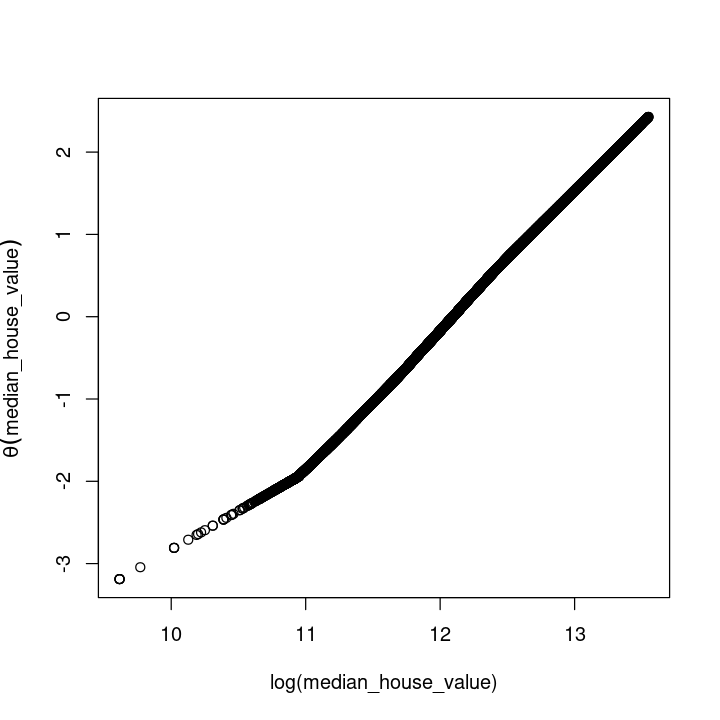

In [136]:
# Look at the transformation on the response variable.

options(repr.plot.width= 6, repr.plot.height= 6)

plot(log(acedat$median_house_value), acefit02$ty, xlab="log(median_house_value)",
     ylab=expression(theta(median_house_value)))


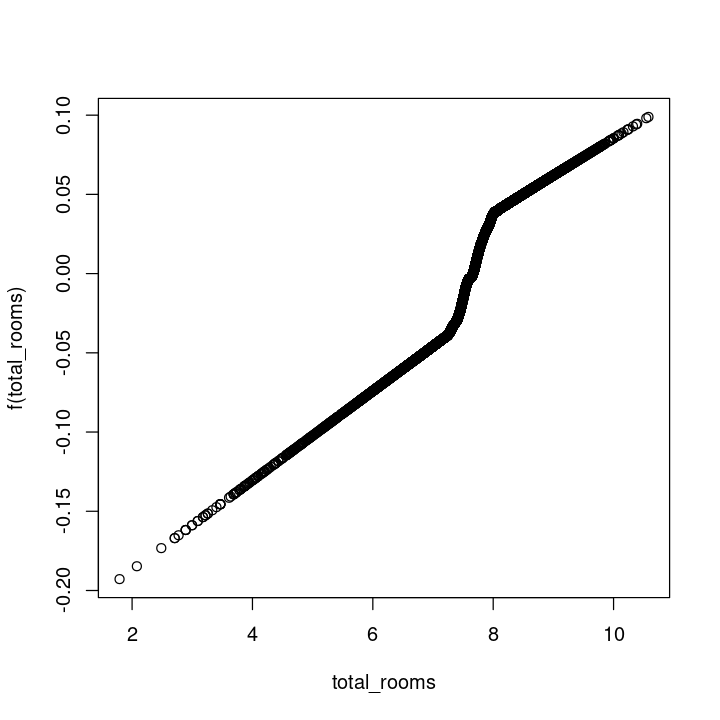

In [140]:
# The transformation on total_rooms.  (This variable already
# has a log transformation on it.)

options(repr.plot.width= 6, repr.plot.height= 6)

plot(acedat$total_rooms, acefit02$tx[, 2], xlab="total_rooms",
     ylab="f(total_rooms)")


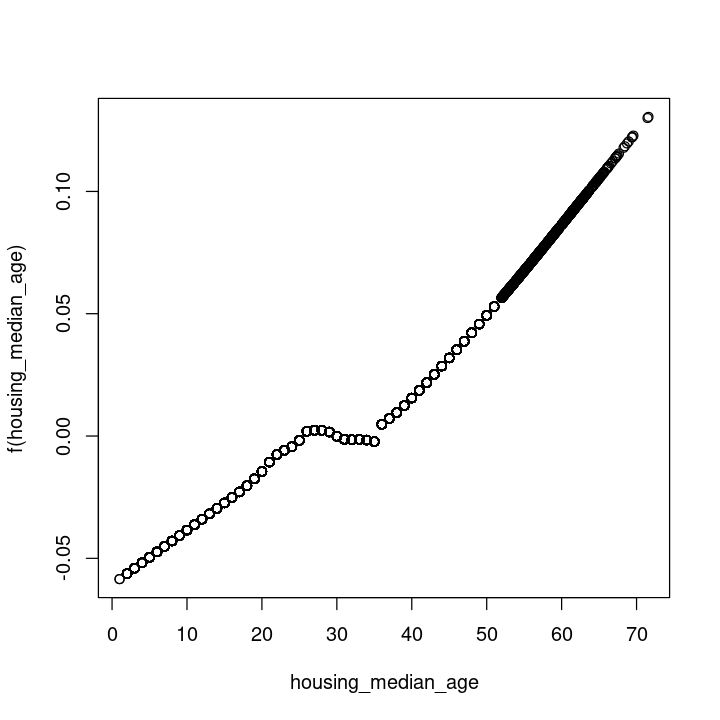

In [141]:
# The transformation on housing_median_age.

options(repr.plot.width= 6, repr.plot.height= 6)

plot(acedat$housing_median_age, acefit02$tx[, 1], 
     xlab="housing_median_age", ylab="f(housing_median_age)")


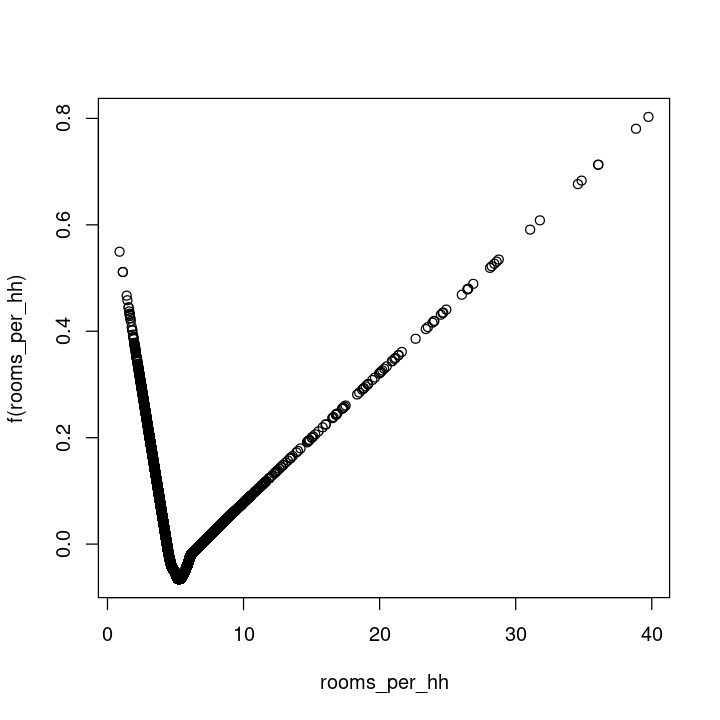

In [143]:
# The transformation on rooms_per_hh.

options(repr.plot.width= 6, repr.plot.height= 6)

plot(acedat$rooms_per_hh, acefit02$tx[, 3], 
     xlab="rooms_per_hh", ylab="f(rooms_per_hh)")


In [152]:
colnames(acefit02$tx)


[1] "housing_median_age" "total_rooms"        "rooms_per_hh"      
 [4] "1"                  "2"                  "1.1"               
 [7] "2.1"                "3"                  "1.2"               
[10] "2.2"                "3.1"                "1.3"               
[13] "2.3"                "3.2"                "1.4"               
[16] "2.4"                "3.3"

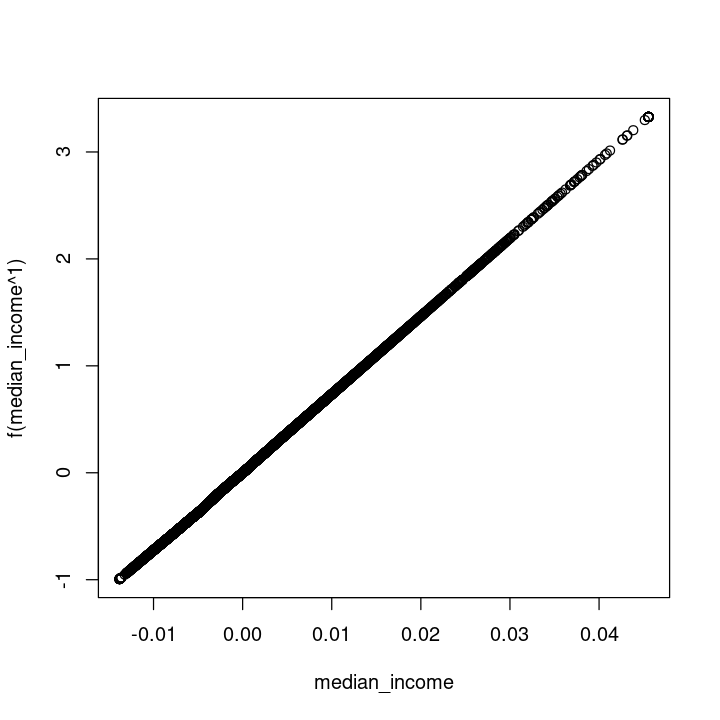

In [145]:
# The transformation on median_income^1.

options(repr.plot.width= 6, repr.plot.height= 6)

plot(acedat[, 5], acefit02$tx[, 4], 
     xlab="median_income", ylab="f(median_income^1)")


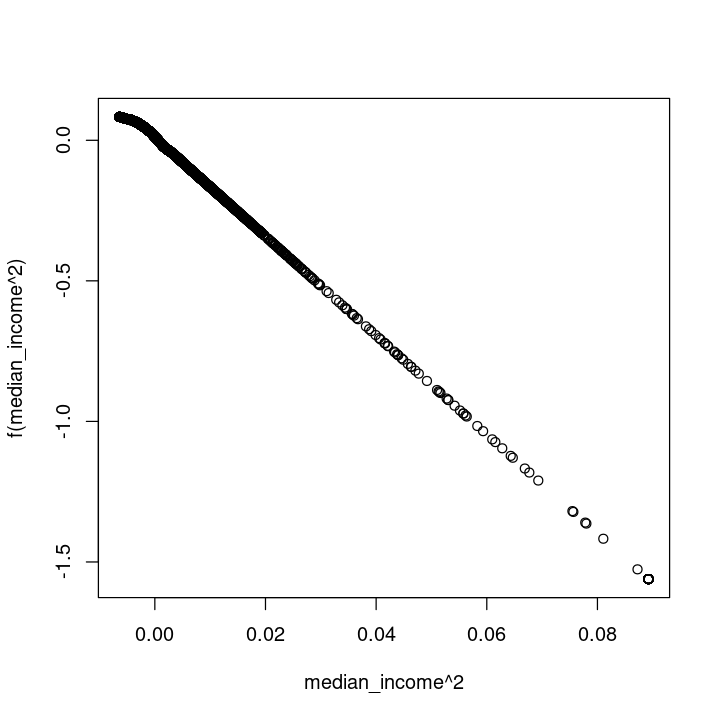

In [147]:
# The transformation on median_income^2.

options(repr.plot.width= 6, repr.plot.height= 6)

plot(acedat[, 6], acefit02$tx[, 5], 
     xlab="median_income^2", ylab="f(median_income^2)")


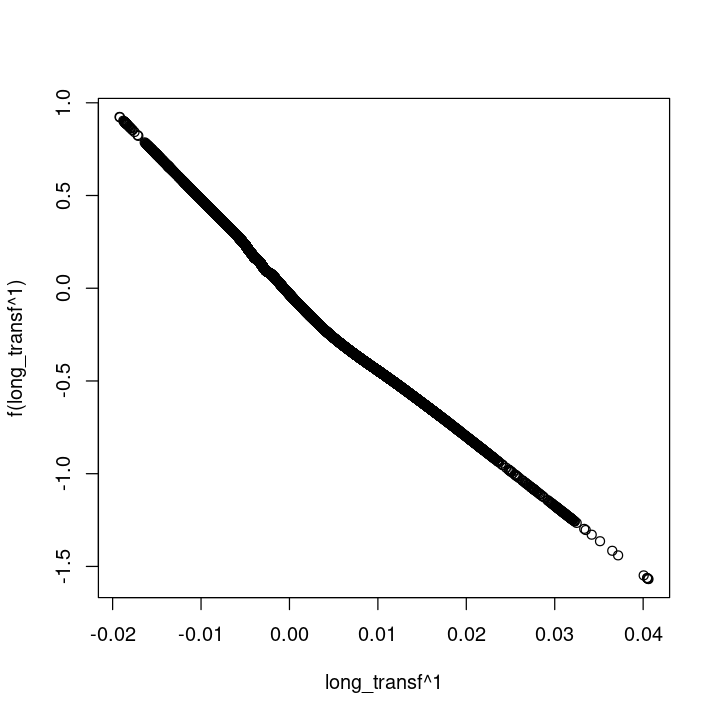

In [153]:
# The transformation on long_transf^1.

options(repr.plot.width= 6, repr.plot.height= 6)

plot(acedat[, 7], acefit02$tx[, 6], 
     xlab="long_transf^1", ylab="f(long_transf^1)")


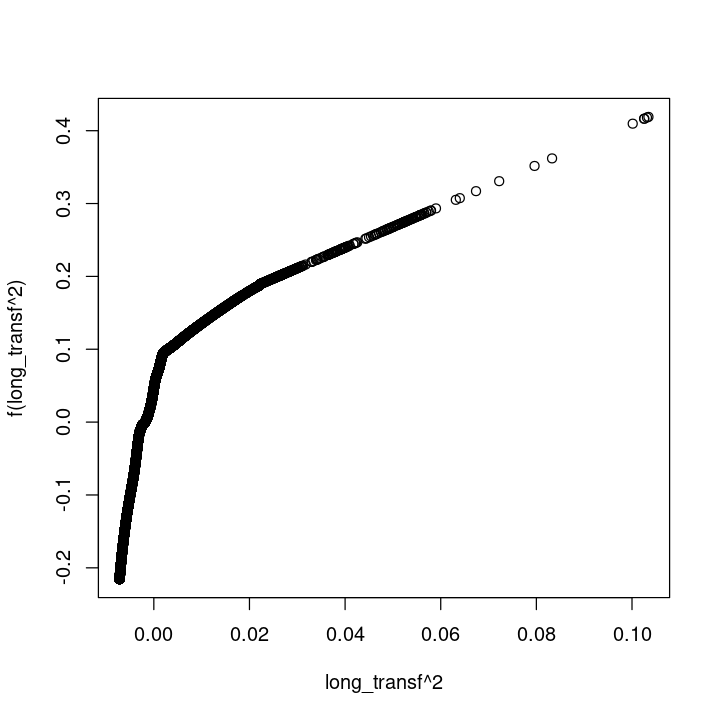

In [154]:
# The transformation on long_transf^2.

options(repr.plot.width= 6, repr.plot.height= 6)

plot(acedat[, 8], acefit02$tx[, 7], 
     xlab="long_transf^2", ylab="f(long_transf^2)")


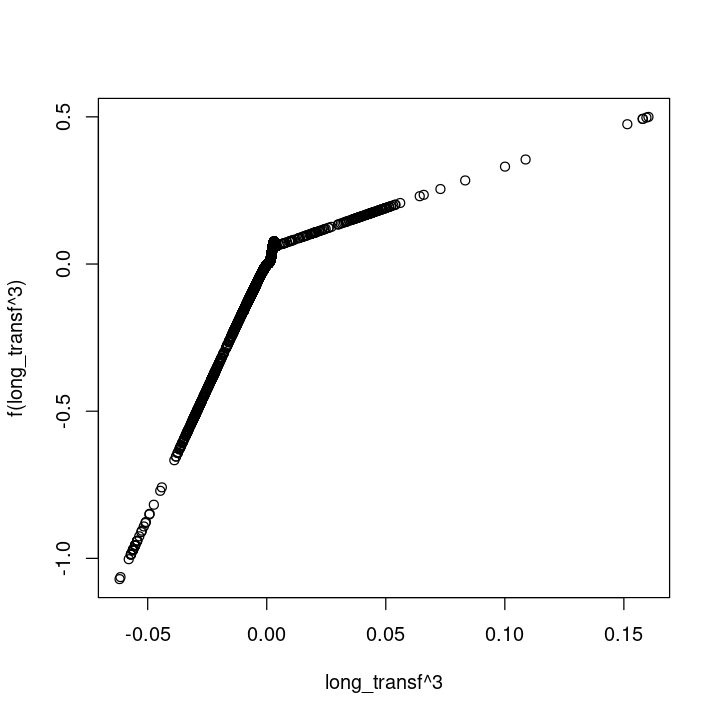

In [155]:
# The transformation on long_transf^3.

options(repr.plot.width= 6, repr.plot.height= 6)

plot(acedat[, 9], acefit02$tx[, 8], 
     xlab="long_transf^3", ylab="f(long_transf^3)")


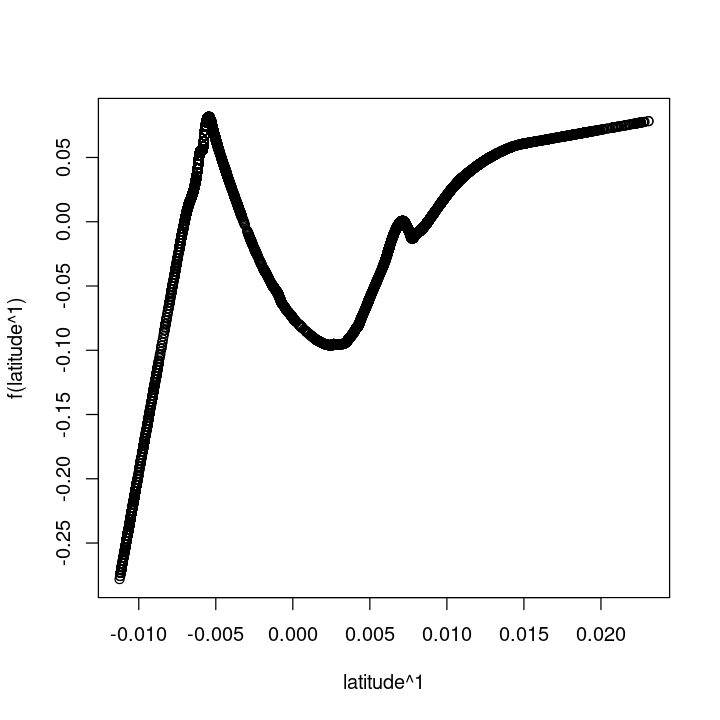

In [156]:
# The transformation on latitude^1.

options(repr.plot.width= 6, repr.plot.height= 6)

plot(acedat[, 10], acefit02$tx[, 9], 
     xlab="latitude^1", ylab="f(latitude^1)")


In [157]:
# Restrict the transformation of latitude^1 so that it is monotone.

acefit03 <- ace(acedat[, -1], log(acedat[, 1]), mon=c(9))

(ace03_sum <- summary(lm(acefit03$ty ~ acefit03$tx)))



Call:
lm(formula = acefit03$ty ~ acefit03$tx)

Residuals:
   Min     1Q Median     3Q    Max 
-3.207 -0.273 -0.019  0.256  3.821 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)
(Intercept)                   -4.40e-15   3.70e-03    0.00    1.000
acefit03$txhousing_median_age  8.22e-01   1.60e-01    5.14  2.8e-07
acefit03$txtotal_rooms         1.18e+00   9.86e-02   11.96  < 2e-16
acefit03$txrooms_per_hh        9.74e-01   5.48e-02   17.76  < 2e-16
acefit03$tx1                   9.82e-01   7.50e-03  131.05  < 2e-16
acefit03$tx2                   9.66e-01   3.08e-02   31.36  < 2e-16
acefit03$tx1.1                 1.00e+00   1.34e-02   74.87  < 2e-16
acefit03$tx2.1                 1.15e+00   4.01e-02   28.77  < 2e-16
acefit03$tx3                   9.97e-01   3.79e-02   26.31  < 2e-16
acefit03$tx1.2                 1.08e+00   4.74e-02   22.72  < 2e-16
acefit03$tx2.2                 1.05e+00   2.85e-02   36.77  < 2e-16
acefit03$tx3.1                 1.56e+0

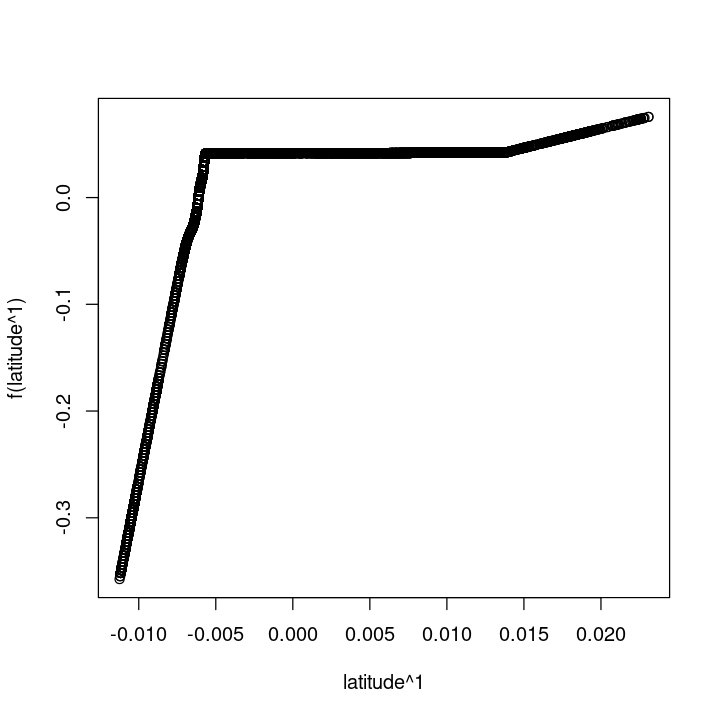

In [158]:
# The restricted transformation on latitude^1.

options(repr.plot.width= 6, repr.plot.height= 6)

plot(acedat[, 10], acefit03$tx[, 9], 
     xlab="latitude^1", ylab="f(latitude^1)")


In [ ]:
### COMMENT:

# We now have to look again at all of the transformations, since
# changing one term in the model can have an effect on the others.
# Below are the new transformations for the model terms already
# looked at above.


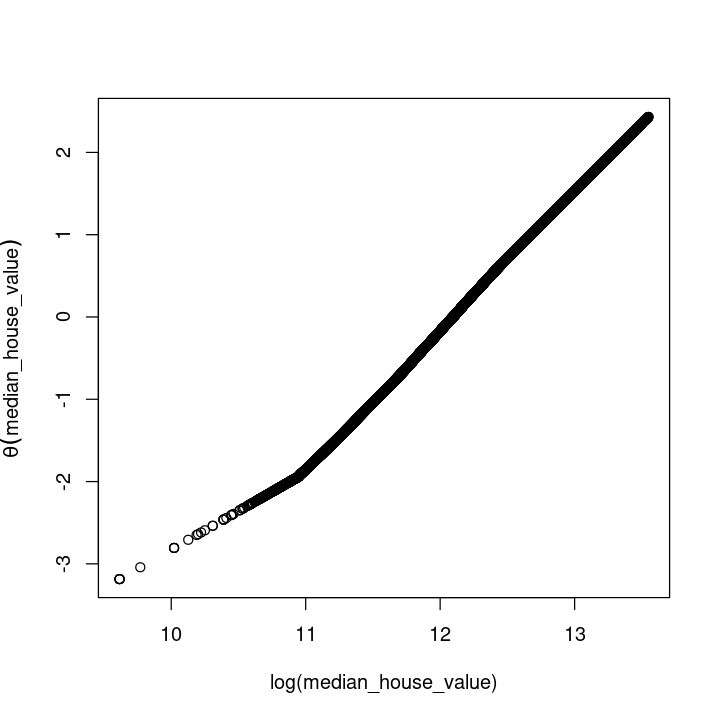

In [159]:
# The transformation on the response variable.

options(repr.plot.width= 6, repr.plot.height= 6)

plot(log(acedat$median_house_value), acefit03$ty, xlab="log(median_house_value)",
     ylab=expression(theta(median_house_value)))


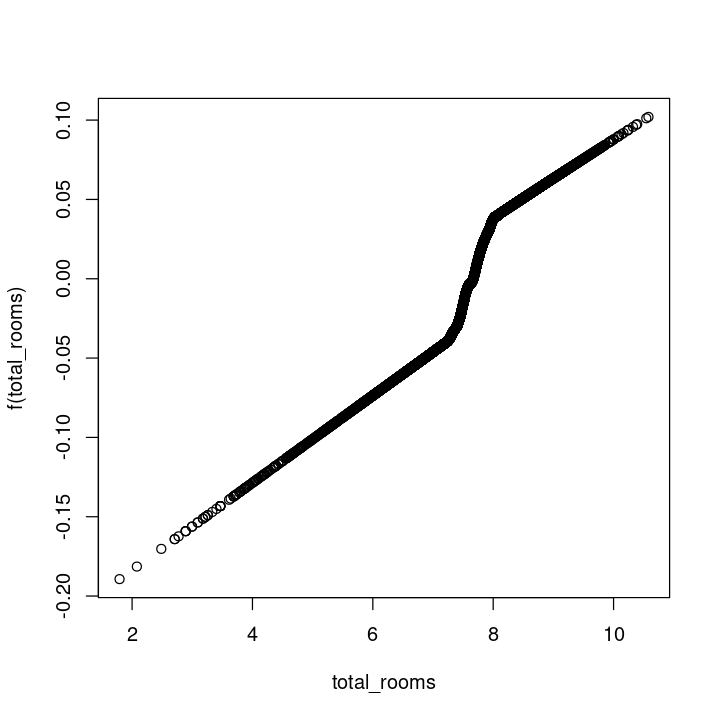

In [160]:
# The transformation on log(total_rooms). 

options(repr.plot.width= 6, repr.plot.height= 6)

plot(acedat$total_rooms, acefit03$tx[, 2], xlab="total_rooms",
     ylab="f(total_rooms)")


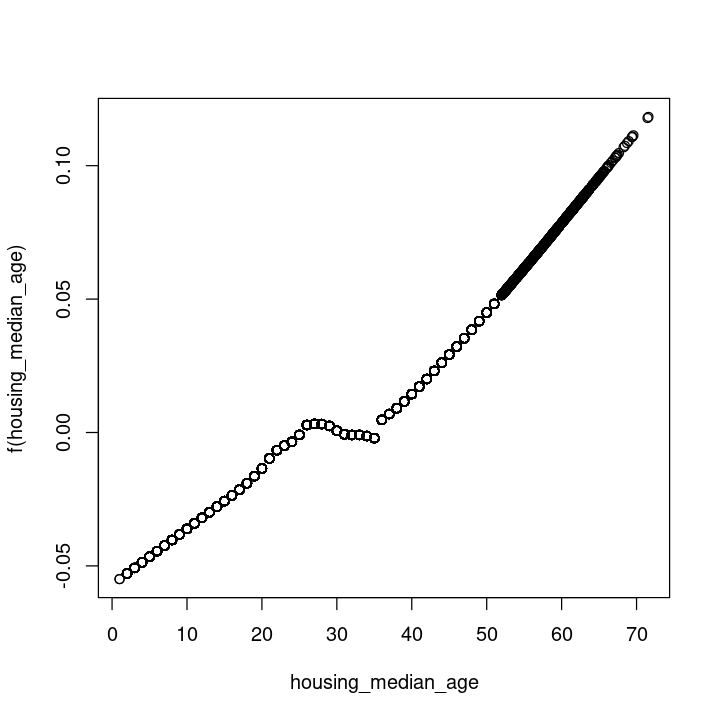

In [161]:
# The transformation on housing_median_age.

options(repr.plot.width= 6, repr.plot.height= 6)

plot(acedat$housing_median_age, acefit03$tx[, 1], 
     xlab="housing_median_age", ylab="f(housing_median_age)")


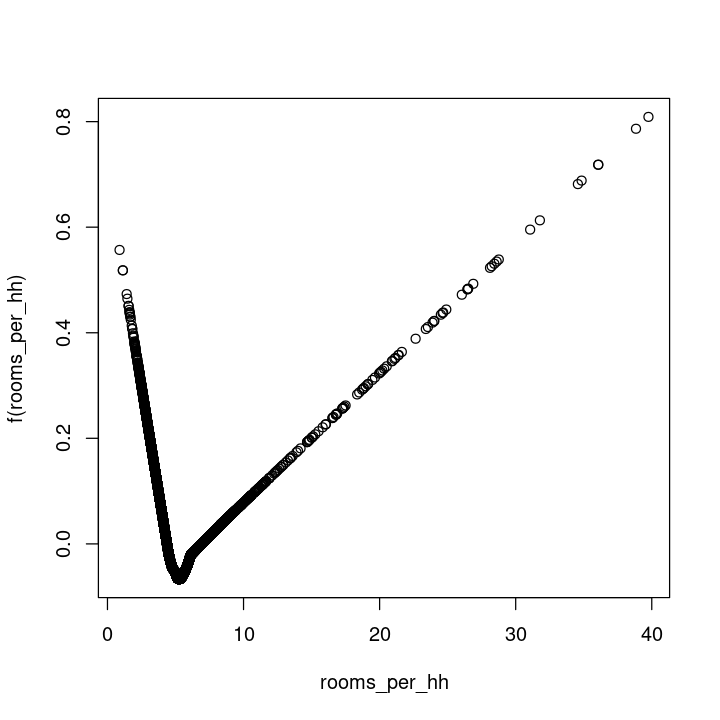

In [162]:
# The transformation on rooms_per_hh.

options(repr.plot.width= 6, repr.plot.height= 6)

plot(acedat$rooms_per_hh, acefit03$tx[, 3], 
     xlab="rooms_per_hh", ylab="f(rooms_per_hh)")


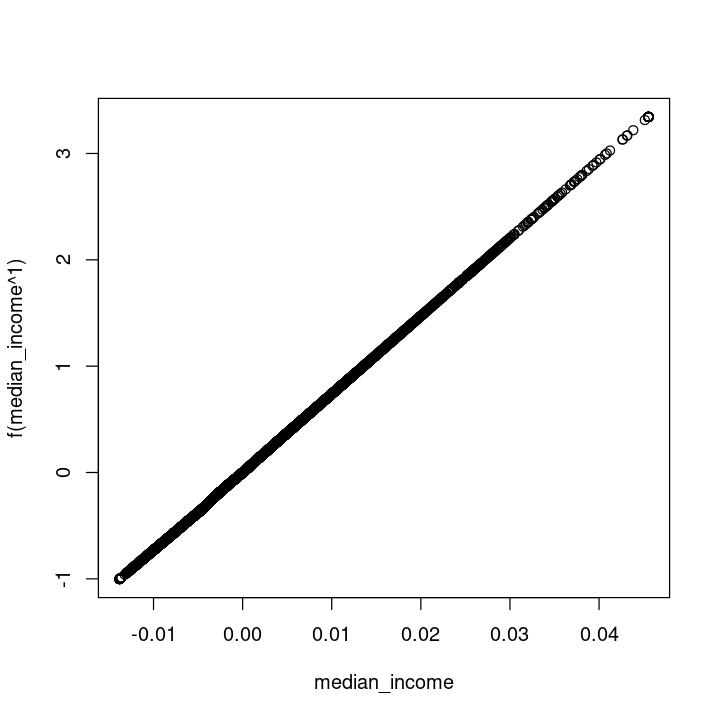

In [163]:
# The transformation on median_income^1.

options(repr.plot.width= 6, repr.plot.height= 6)

plot(acedat[, 5], acefit03$tx[, 4], 
     xlab="median_income", ylab="f(median_income^1)")


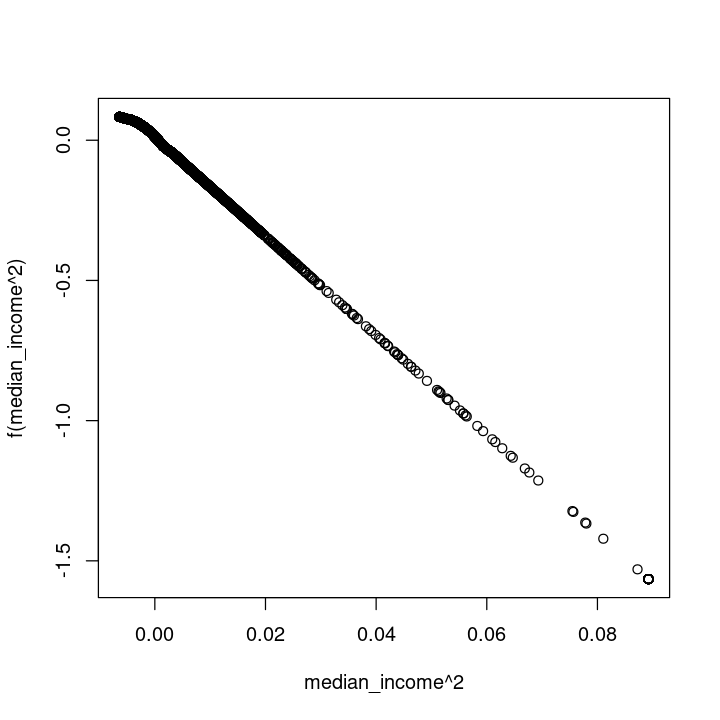

In [164]:
# The transformation on median_income^2.

options(repr.plot.width= 6, repr.plot.height= 6)

plot(acedat[, 6], acefit03$tx[, 5], 
     xlab="median_income^2", ylab="f(median_income^2)")


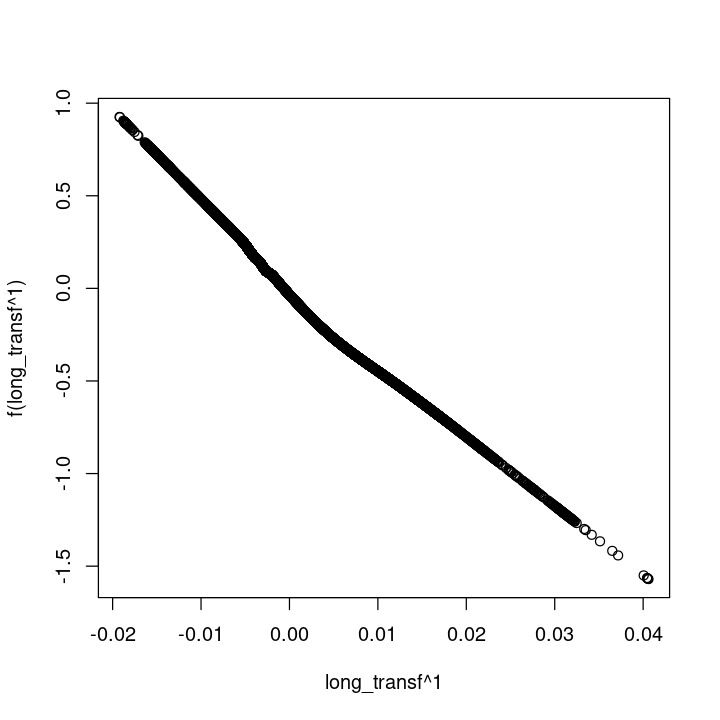

In [165]:
# The transformation on long_transf^1.

options(repr.plot.width= 6, repr.plot.height= 6)

plot(acedat[, 7], acefit03$tx[, 6], 
     xlab="long_transf^1", ylab="f(long_transf^1)")


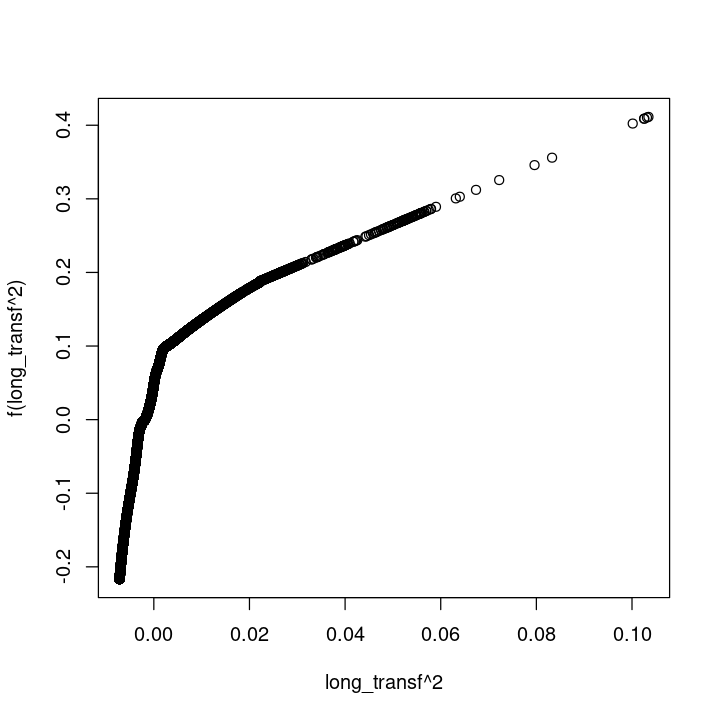

In [166]:
# The transformation on long_transf^2.

options(repr.plot.width= 6, repr.plot.height= 6)

plot(acedat[, 8], acefit03$tx[, 7], 
     xlab="long_transf^2", ylab="f(long_transf^2)")


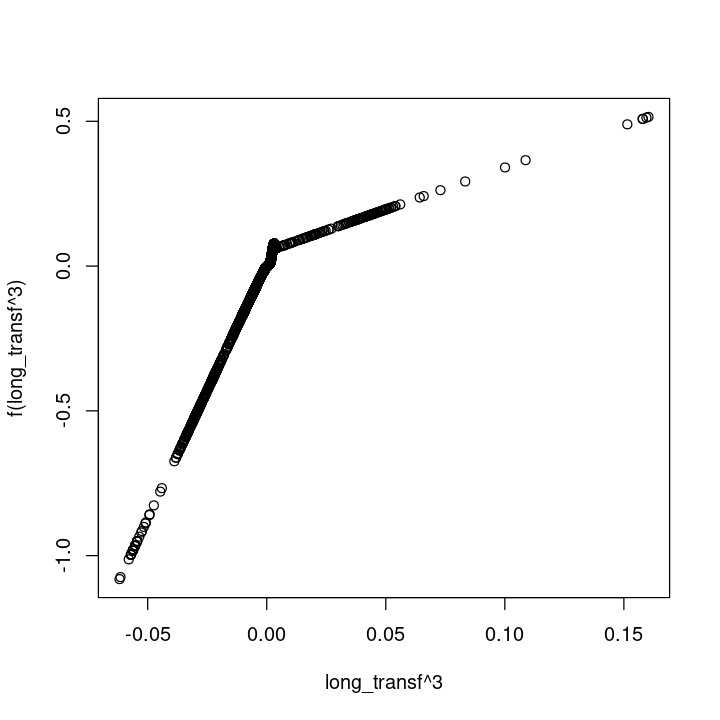

In [167]:
# The transformation on long_transf^3.

options(repr.plot.width= 6, repr.plot.height= 6)

plot(acedat[, 9], acefit03$tx[, 8], 
     xlab="long_transf^3", ylab="f(long_transf^3)")


In [ ]:
### COMMENTS:

# All of the transformations reviewed above can be 
# implemented without too much trouble, I think.  We
# can use simple linear regression and piecewise 
# linear regression for the plots which have a 
# hockey-stick appearance.  So getting new predictions, 
# such as for our test set data, can still be done very
# quickly.  What will require some work, though, is testing
# whether the polynomial transformations are needed
# and whether it is worth looking at any interactions.
# This evaluation of the different models would 
# require some effort.
